# Predicting road accidents in Spain
In Spain, road accidents remain a significant public safety concern, leading to loss of lives (1.154 people lost their live on inter-urban roads in 2024), injuries (4.634 hospital admissions in 2024), and economic burdens. Despite various measures, predicting and preventing these incidents remains a challenge. This project aims to leverage the power of machine learning to identify high-risk scenarios and suggest preventive measures.

The aim of this project is to build a model that can predict if a road accident will have mortal victims or not, to be able to find which are the more relevant factors that lead to fatalities on the road.

With the identification of these factors some conclusions will be obtained that may help to provide measures that can prevent losses of lives.

The data used for this project is the [Ficheros microdatos de accidentes con víctimas 2023](https://www.dgt.es/menusecundario/dgt-en-cifras/dgt-en-cifras-resultados/dgt-en-cifras-detalle/Ficheros-microdatos-de-accidentes-con-victimas-2023/) by the Spanish General Traffic Administration ([DGT - Dirección General de Tráfico)](https://www.dgt.es/). In the dataset webpage we have an excel file with the data and another one with the diccionary of the category identifiers.

Let's first of all import the data and the necessary Python packages for the analysis.



In [1]:
import pandas as pd

# URL of the Excel file to be used as dataser
url = "https://www.dgt.es/export/sites/web-DGT/.galleries/downloads/dgt-en-cifras/24h/TABLA_ACCIDENTES_23.XLSX"

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(url, sheet_name='ACCIDENTES_23', engine='openpyxl')

# Display the DataFrame
df.head()

,ID_ACCIDENTE,ANYO,MES,DIA_SEMANA,HORA,COD_PROVINCIA,COD_MUNICIPIO,ISLA,ZONA,ZONA_AGRUPADA,...,PRIORI_OTRA,CONDICION_NIVEL_CIRCULA,CONDICION_FIRME,CONDICION_ILUMINACION,CONDICION_METEO,CONDICION_NIEBLA,CONDICION_VIENTO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA
0,1,2023,1,1,7,1,0,NaN,1,1,...,999,1,3,6,3,NaN,NaN,1,998,1
1,2,2023,1,1,5,1,1059,NaN,1,1,...,0,1,3,4,3,NaN,NaN,1,998,2
2,3,2023,1,2,9,1,0,NaN,3,2,...,0,1,1,1,1,NaN,NaN,1,998,998
3,4,2023,1,4,13,1,0,NaN,1,1,...,999,1,1,1,1,NaN,NaN,1,998,1
4,5,2023,1,6,3,1,0,NaN,1,1,...,999,1,1,4,1,NaN,NaN,1,998,3


First of all, let's drop the `ANYO` (year) column as all the data is from 2023 and the column is not giving us any additional relevant information. We will also drop the `ID_ACCIDENTE` column as we also don't need it.

In [2]:
df = df.drop('ANYO', axis=1)
df = df.drop('ID_ACCIDENTE', axis=1)

Now, let's tell Pandas which of the columns we have are categorical as most of the columns we have are categorical.

In [3]:
# List the category columns
category_columns = ['MES',
                    'HORA',
                    'DIA_SEMANA',
                    'COD_PROVINCIA',
                    'COD_MUNICIPIO',
                    'ISLA',
                    'ZONA',
                    'ZONA_AGRUPADA',
                    'SENTIDO_1F',
                    'TITULARIDAD_VIA',
                    'TIPO_VIA',
                    'TIPO_ACCIDENTE',
                    'NUDO',
                    'NUDO_INFO',
                    'PRIORI_NORMA',
                    'PRIORI_AGENTE',
                    'PRIORI_SEMAFORO',
                    'PRIORI_VERT_STOP',
                    'PRIORI_VERT_CEDA',
                    'PRIORI_HORIZ_STOP',
                    'PRIORI_HORIZ_CEDA',
                    'PRIORI_MARCAS',
                    'PRIORI_PEA_NO_ELEV',
                    'PRIORI_PEA_ELEV',
                    'PRIORI_MARCA_CICLOS',
                    'PRIORI_CIRCUNSTANCIAL',
                    'PRIORI_OTRA',
                    'CONDICION_NIVEL_CIRCULA',
                    'CONDICION_FIRME',
                    'CONDICION_ILUMINACION',
                    'CONDICION_METEO',
                    'CONDICION_NIEBLA',
                    'CONDICION_VIENTO',
                    'VISIB_RESTRINGIDA_POR',
                    'ACERA',
                    'TRAZADO_PLANTA']

# Convert to category columns
df[category_columns] = df[category_columns].astype('category')

Now we want to create a new column which will indicate if an accident has had mortal victims or not. We will do it by using the column `TOTAL_MU30DF`, which indicates the total number of deceased after 30 days of the accident. If this number is greater than 0 it will mean that the accident has led to fatal victims.

In [4]:
df['FATAL_ACCIDENT'] = df['TOTAL_MU30DF'].apply(lambda x: 1 if x > 0 else 0)

Let's explore the data. First of all, I want to see how many fatal accidents are in relationship with how many non fatal accidents.

In [5]:
df['FATAL_ACCIDENT'].value_counts() / df.shape[0]

,count
FATAL_ACCIDENT,
0,0.983417
1,0.016583


We can see that we have a clear case of class imbalance. Class imbalance means that we have a very small amount of accidents with fatal victims and a huge amount of accidents without fatal victims.

I will randomly eliminate accidents without fatal victims.

In [6]:
# Select all accidents without fatal victims
df_without_fatal = df[df['FATAL_ACCIDENT'] == 0]

# Randomly sample the same amount of non fatal accidents than fatal accidents
df_without_fatal = df_without_fatal.sample(n=df['FATAL_ACCIDENT'].value_counts()[1])

# Merge and shuffle fatal and non fatal accidents
df_balanced = pd.concat([df[df['FATAL_ACCIDENT'] == 1], df_without_fatal]).sample(frac=1).reset_index(drop=True)

# Check that the df is balanced
df_balanced['FATAL_ACCIDENT'].value_counts() / df_balanced.shape[0]

,count
FATAL_ACCIDENT,
1,0.5
0,0.5


Let's now explore our balanced DataFrame to compare it with our original DataFrame and see it is representative enough to fit our model in an effective way.

For this, we will use the some plots on both datasets and compare the occurrences of categories.

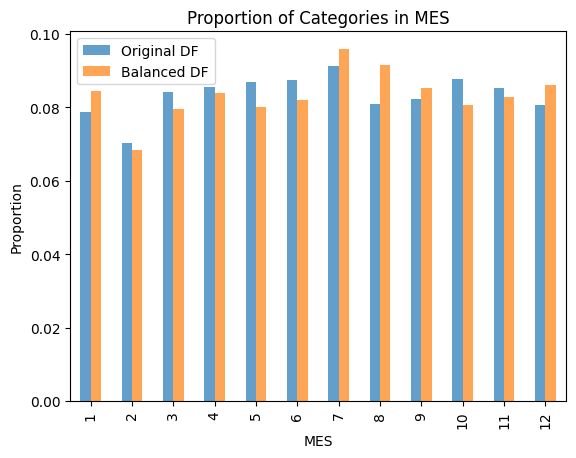

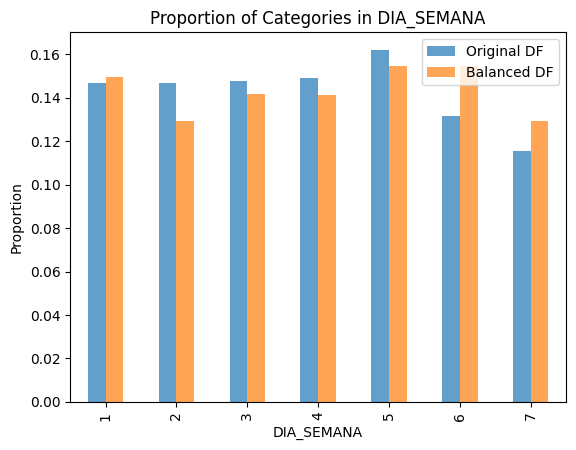

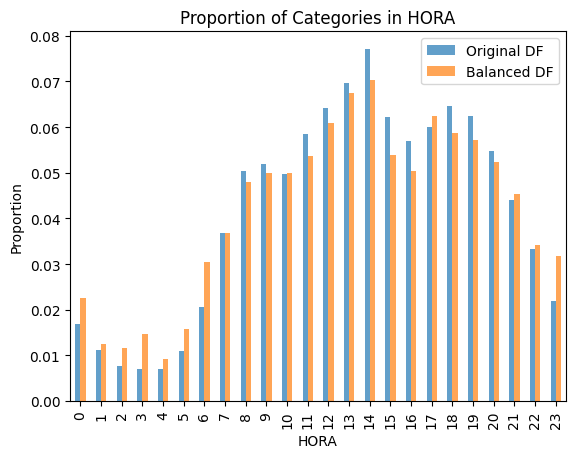

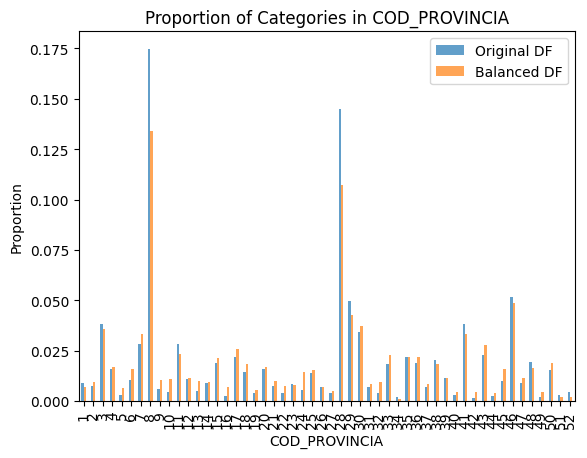

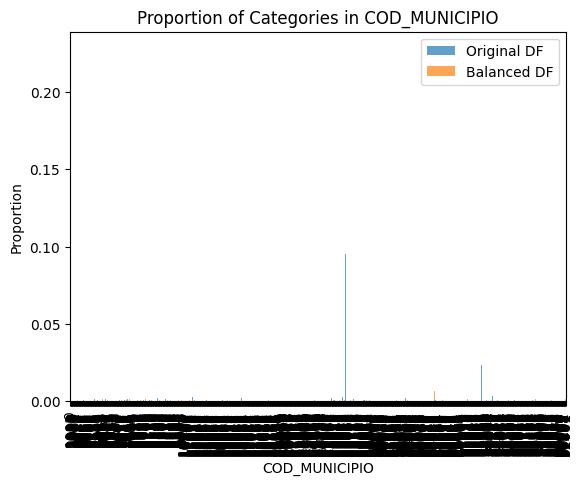

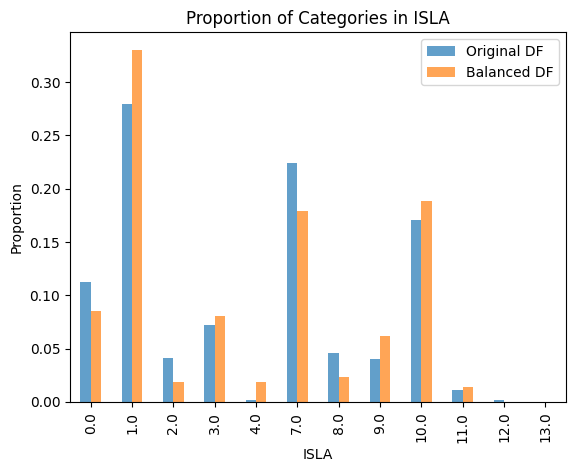

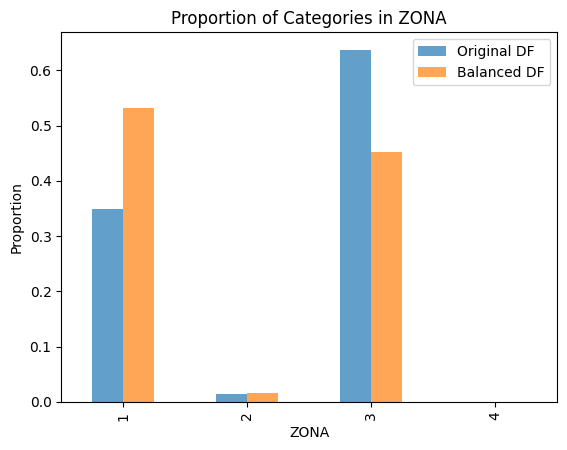

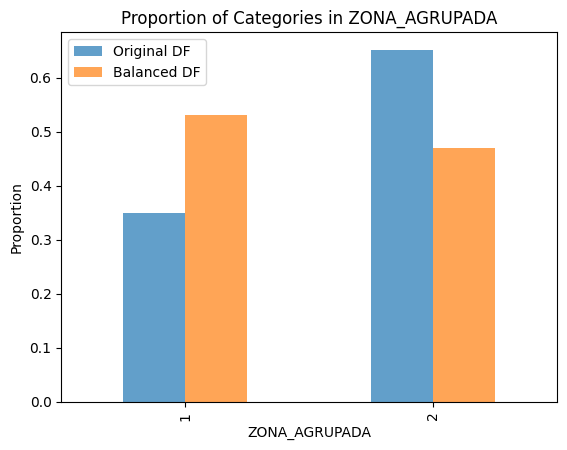

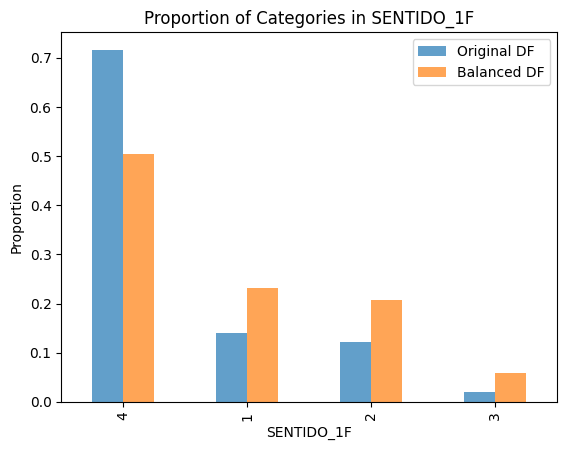

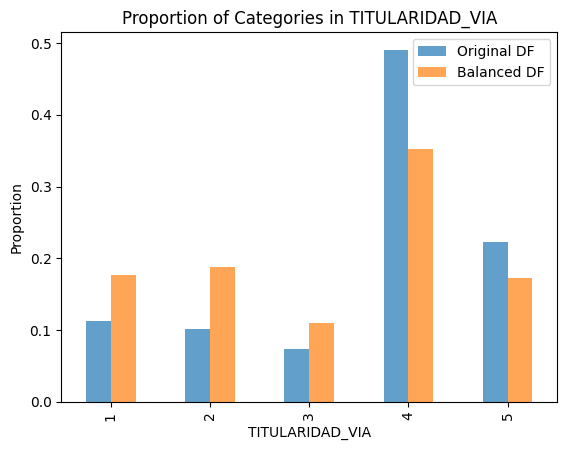

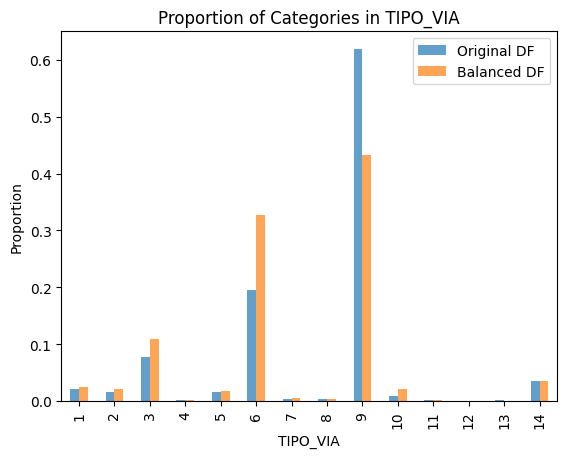

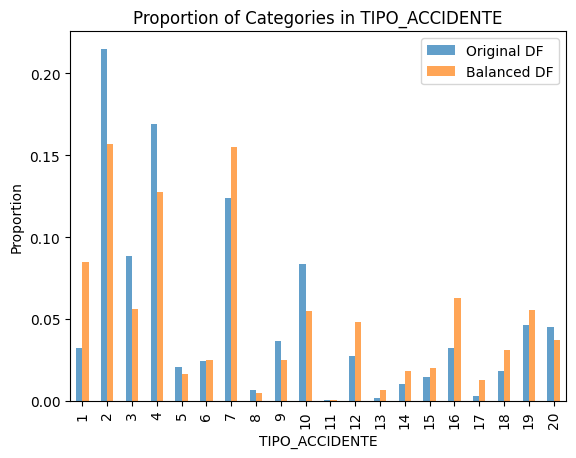

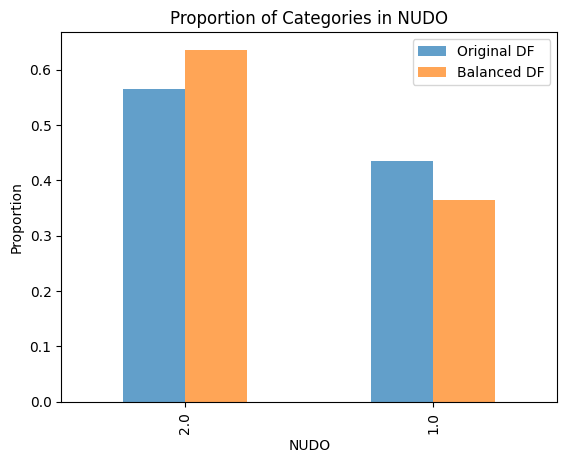

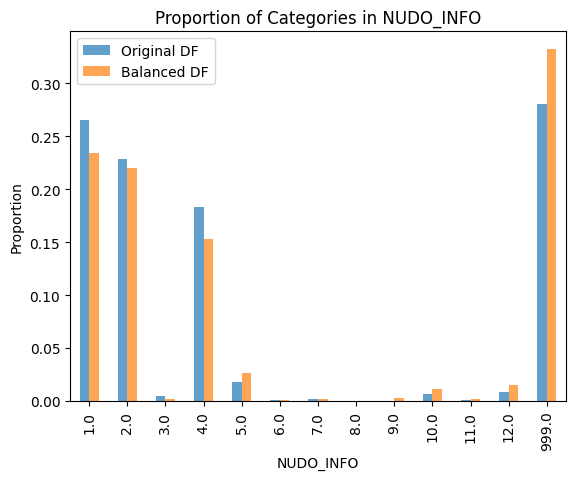

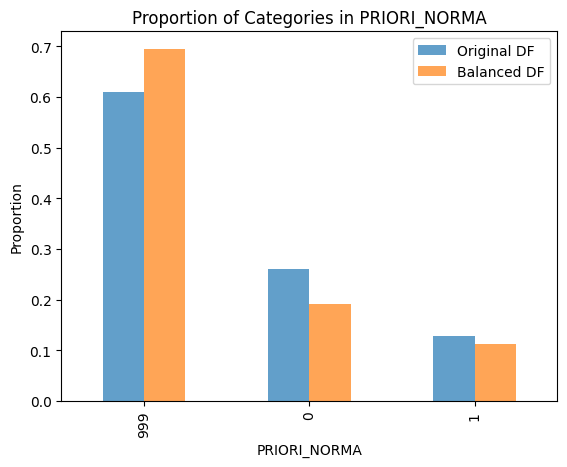

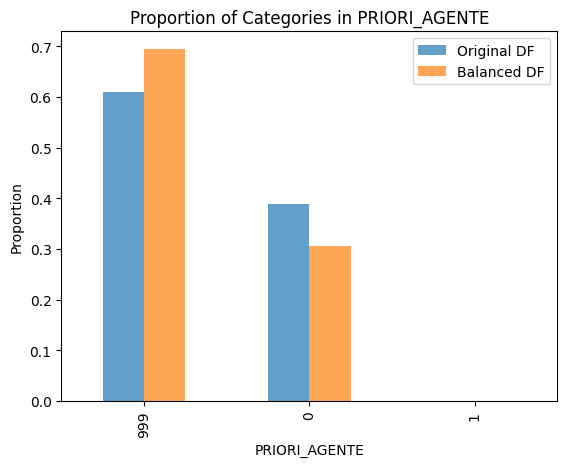

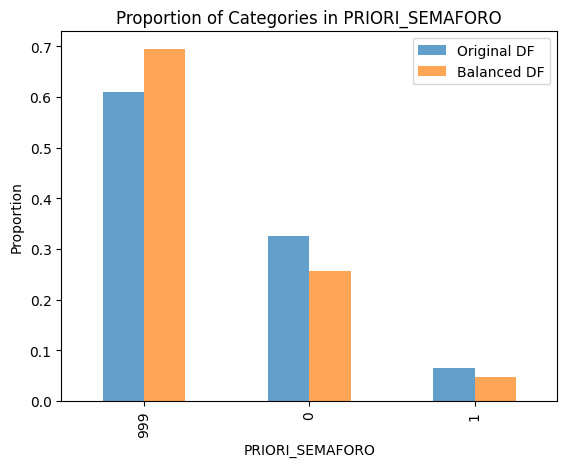

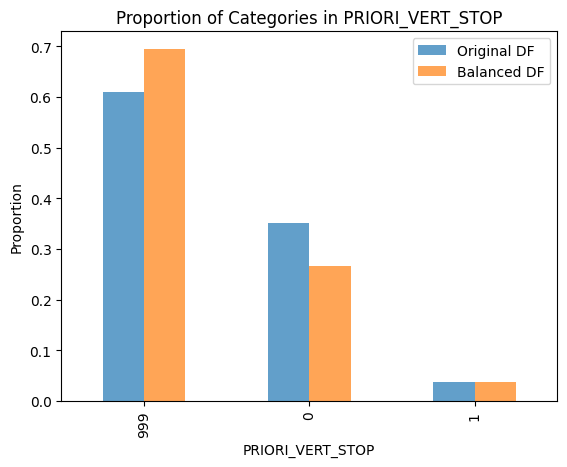

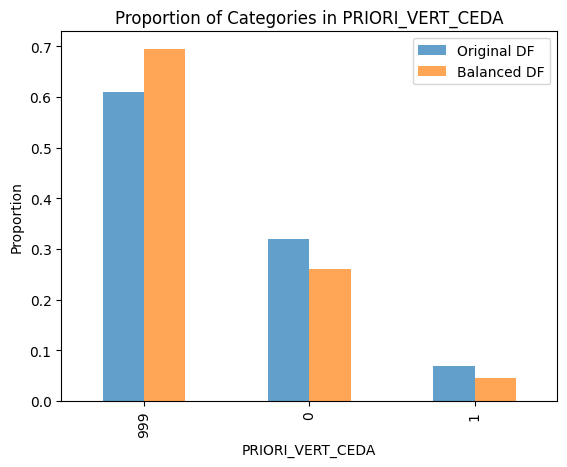

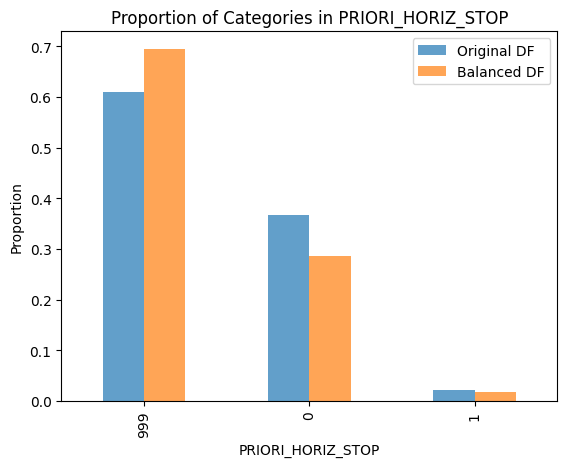

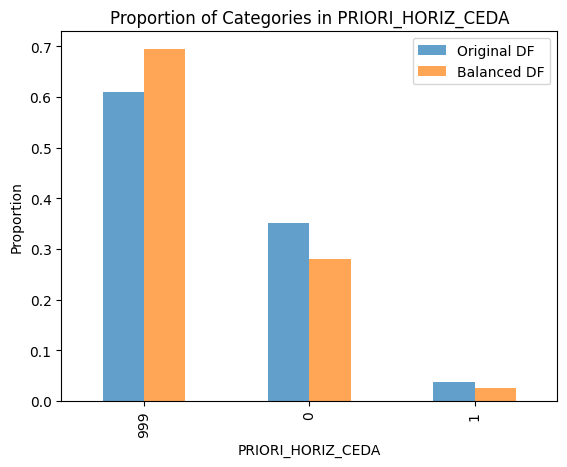

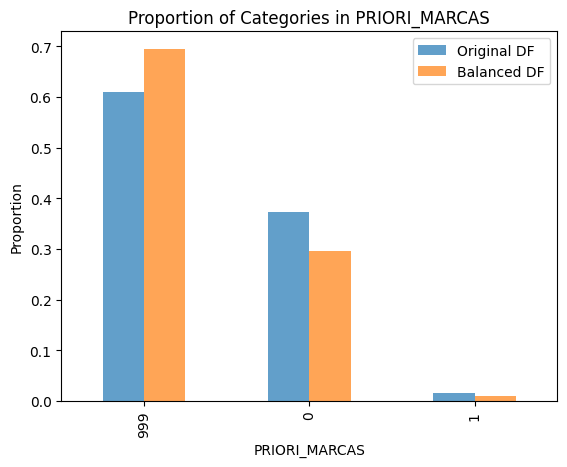

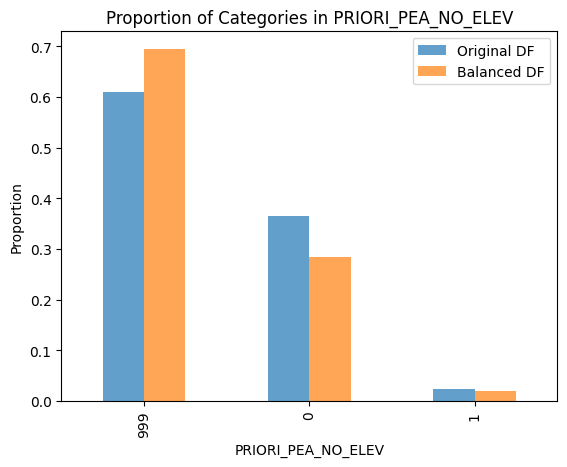

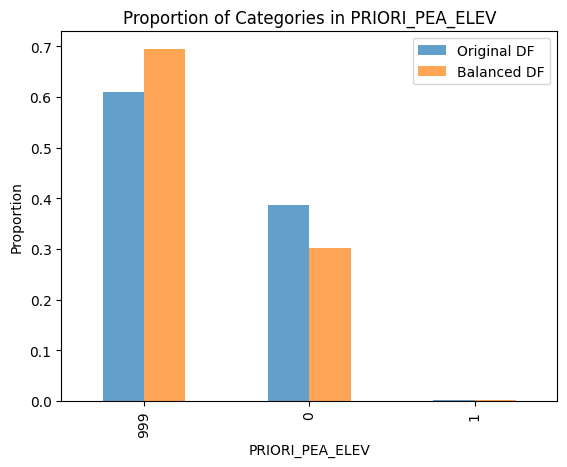

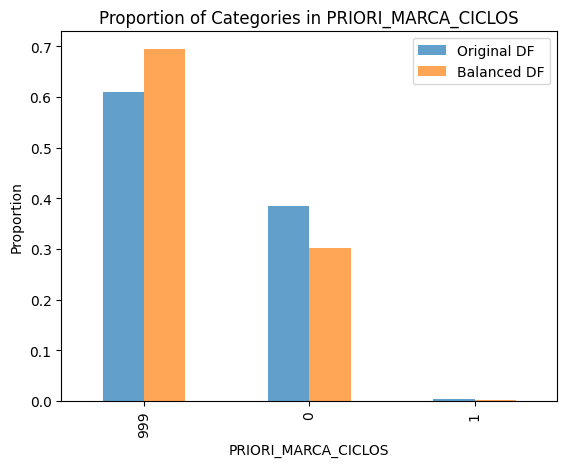

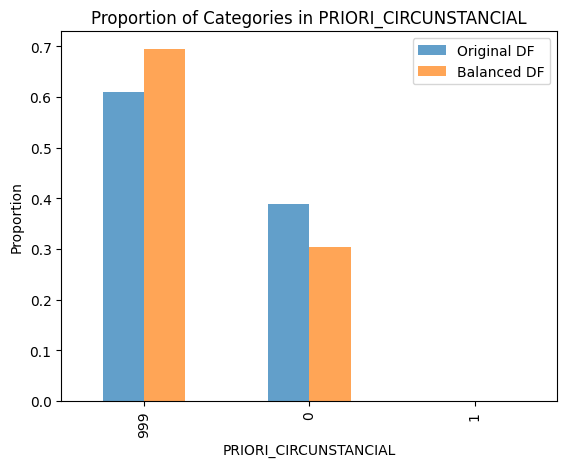

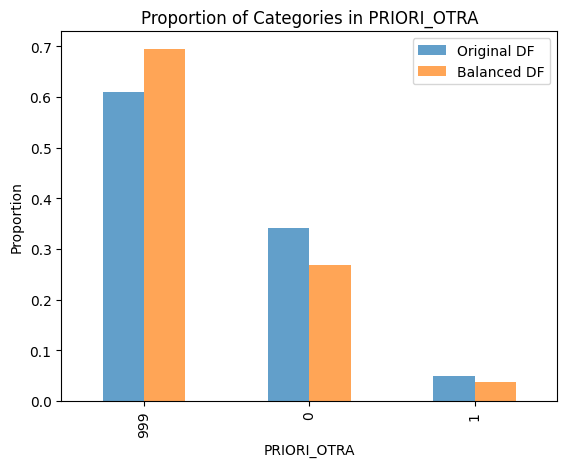

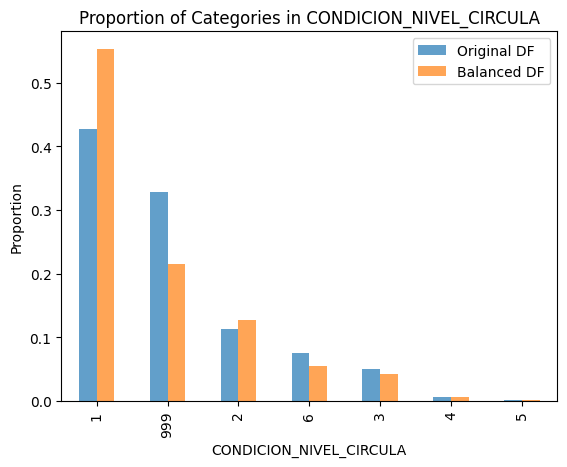

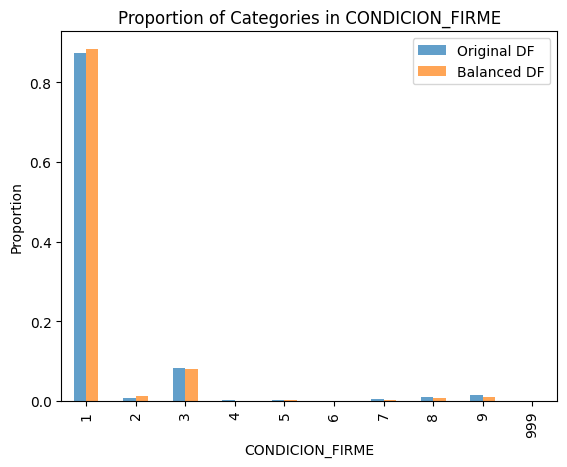

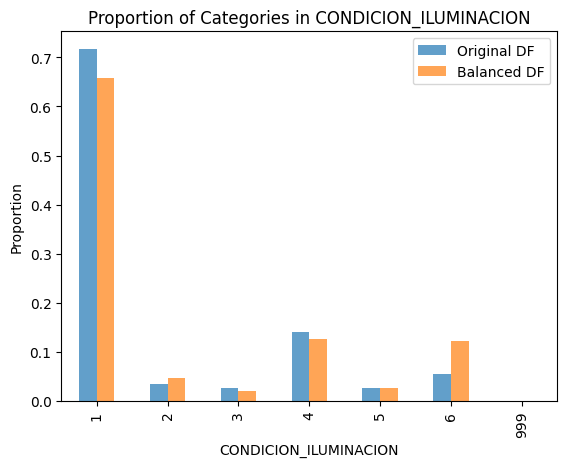

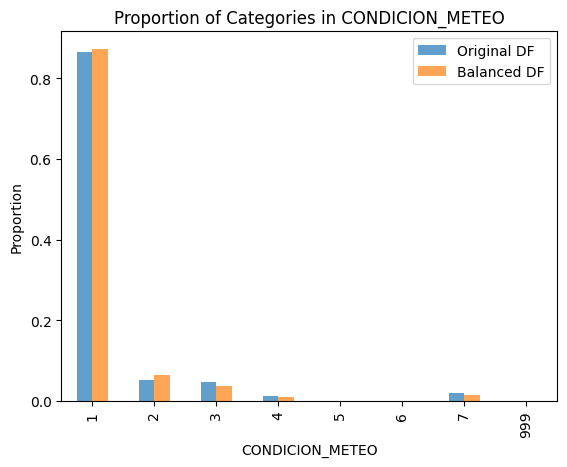

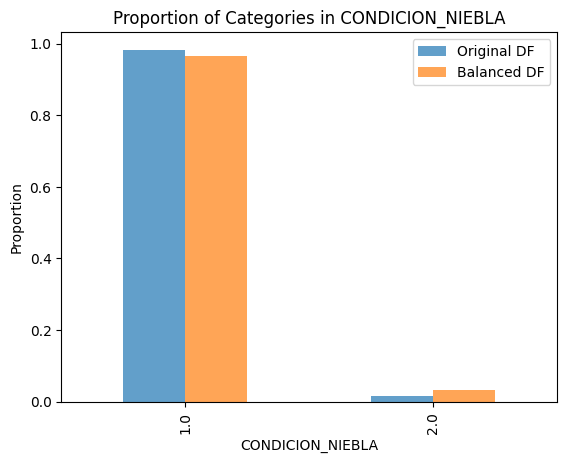

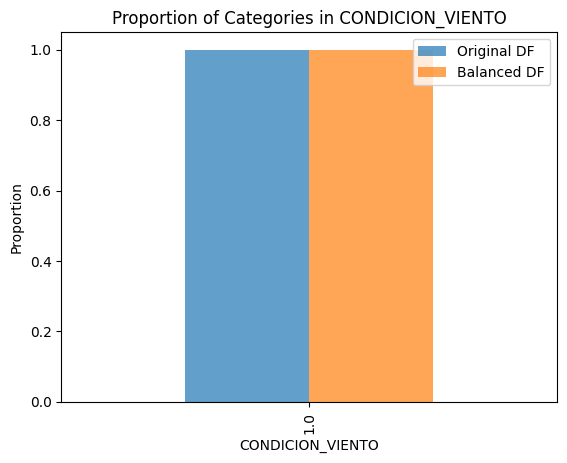

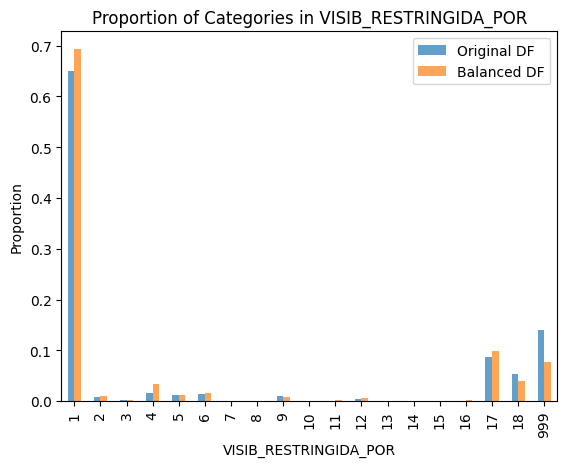

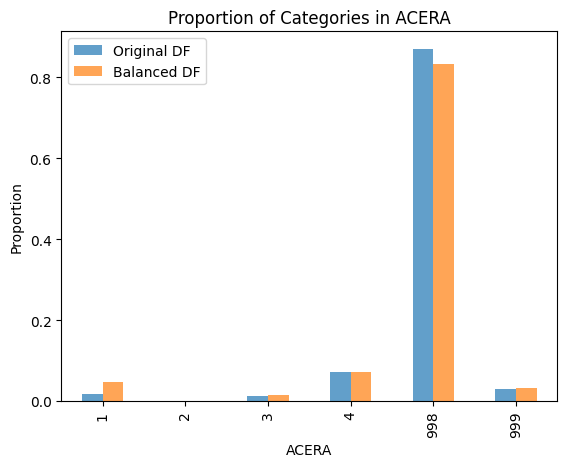

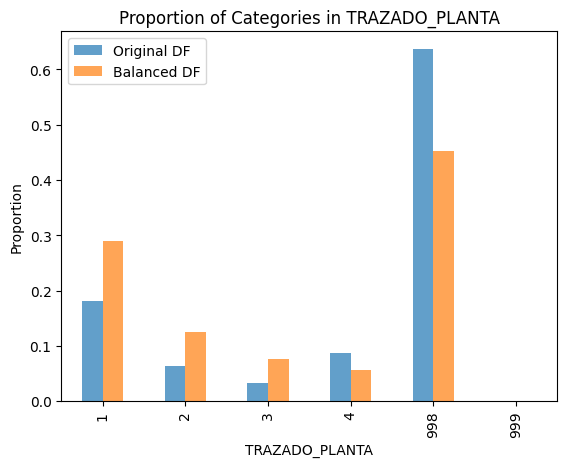

In [7]:
import matplotlib.pyplot as plt

for column in df.select_dtypes(include=['category']).columns:
  # Calculate proportions
  original_proportions = df[column].value_counts(normalize=True)
  balanced_proportions = df_balanced[column].value_counts(normalize=True)

  # Create a DataFrame for plotting
  proportions_df = pd.DataFrame({'Original DF': original_proportions,
                                 'Balanced DF': balanced_proportions}).fillna(0)

  # Plot the proportions
  proportions_df.plot(kind='bar', alpha=0.7)
  plt.title(f'Proportion of Categories in {column}')
  plt.ylabel('Proportion')
  plt.show()

As we can see, most of the categorical variables have similar distributions in both datasets.

Let's now see the difference between distributions for fatal accidents and non fatal accidents.

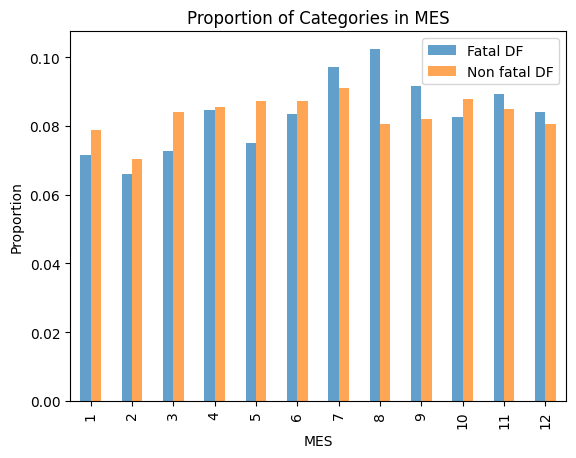

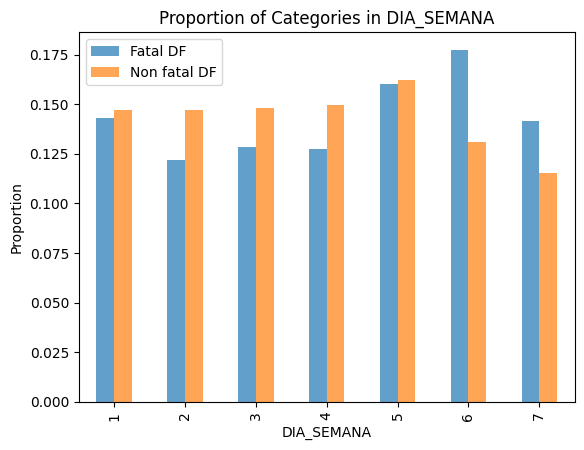

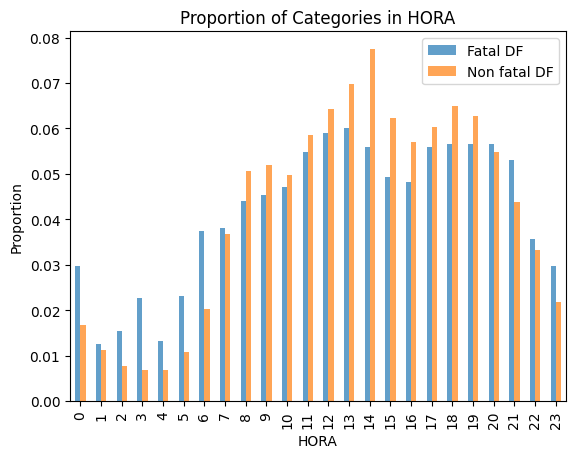

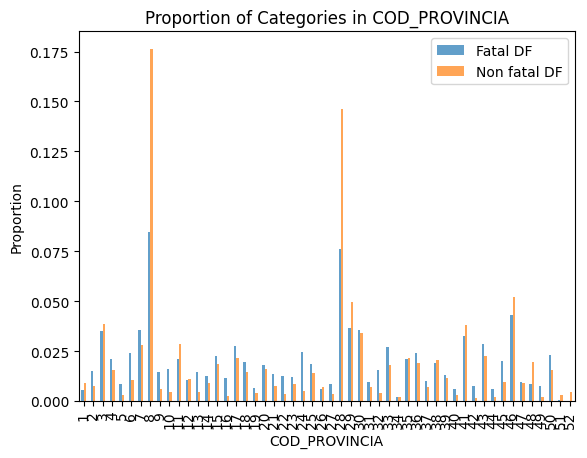

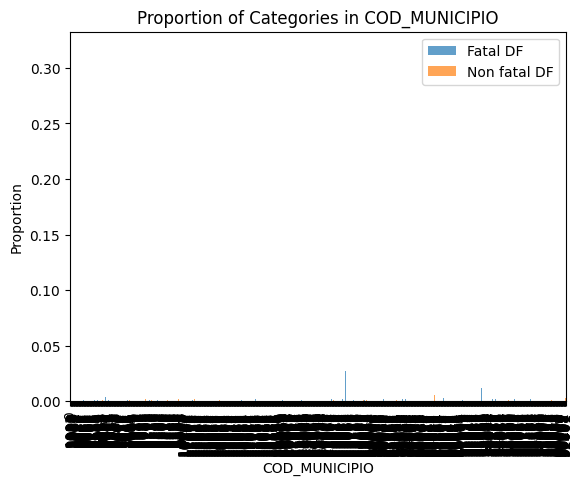

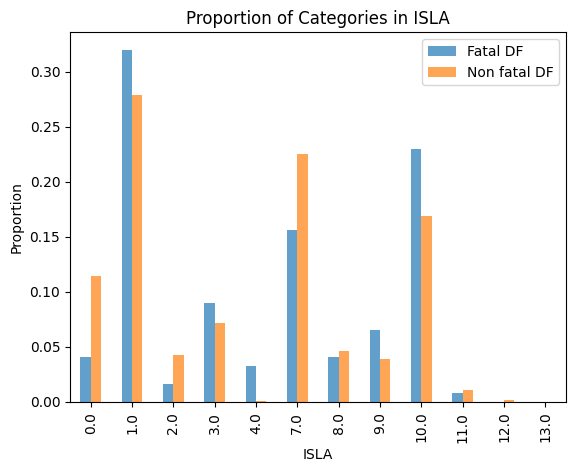

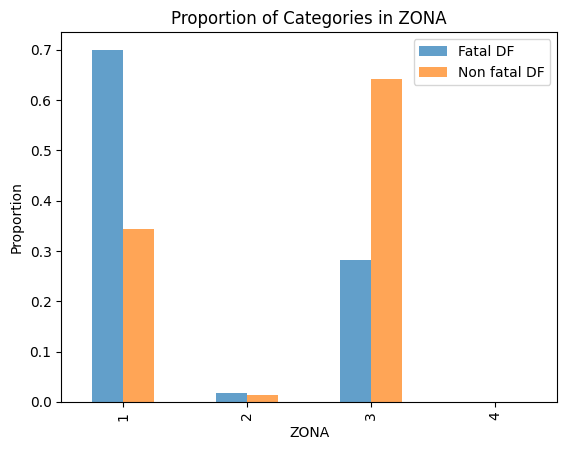

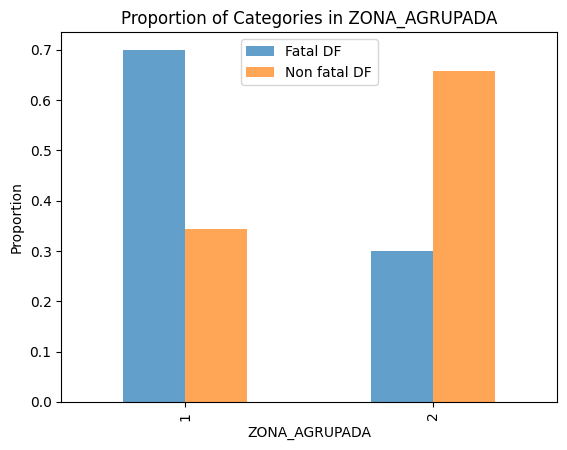

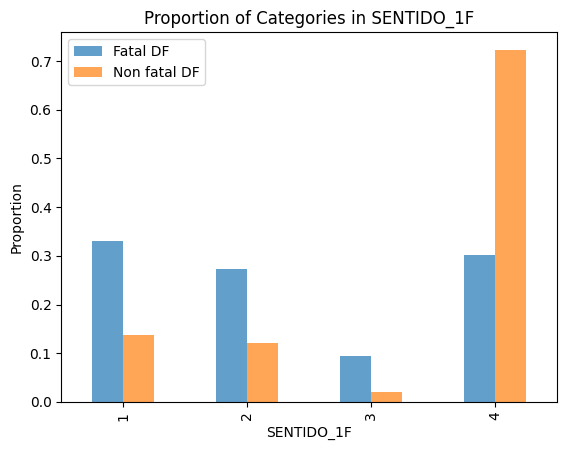

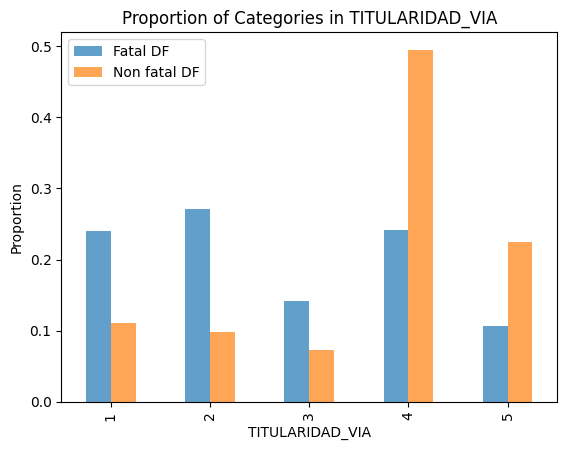

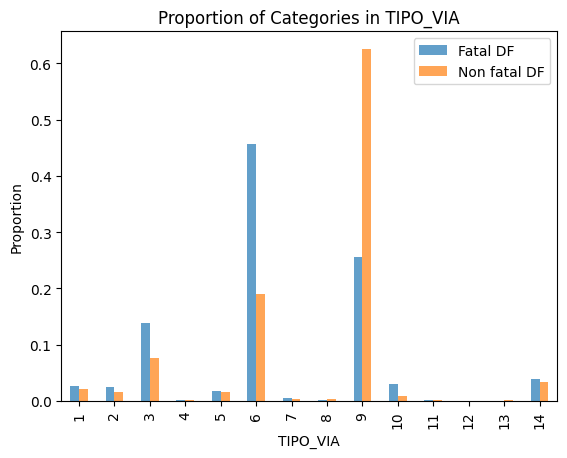

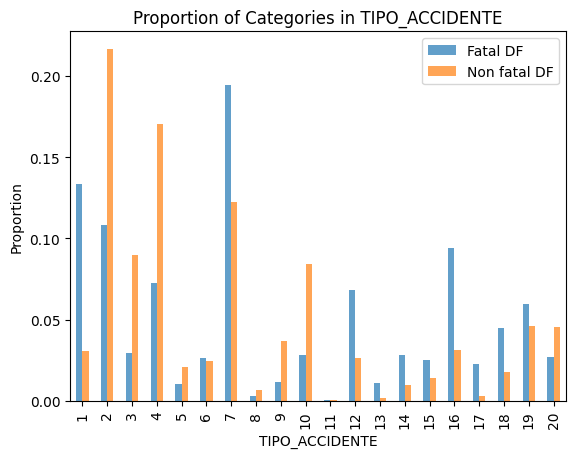

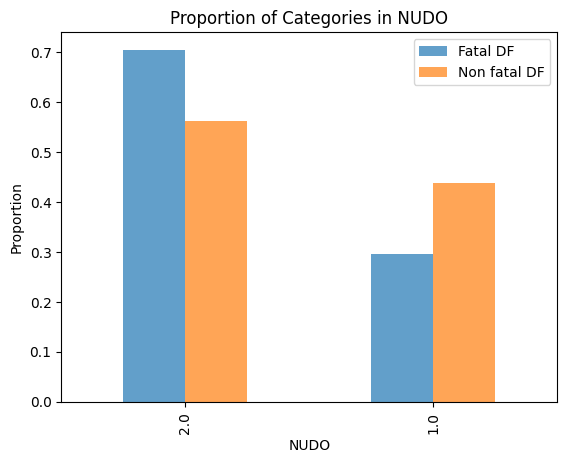

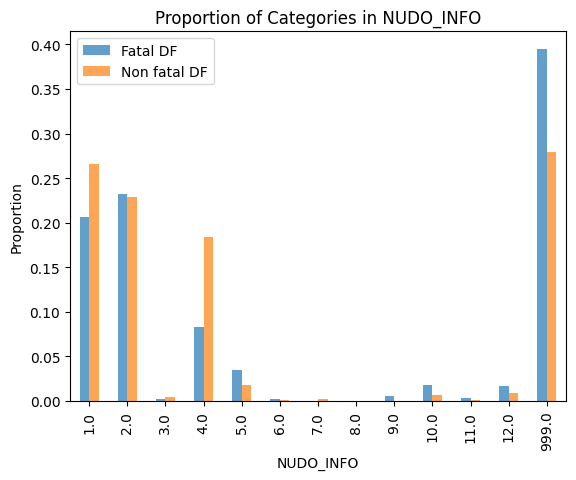

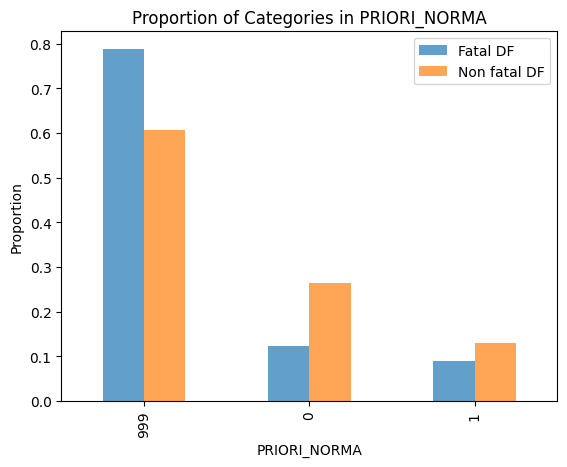

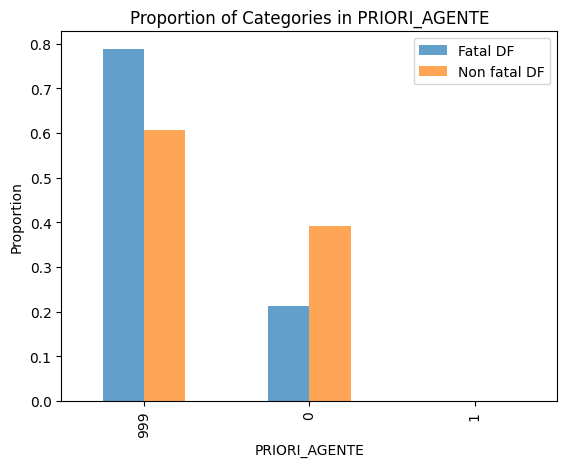

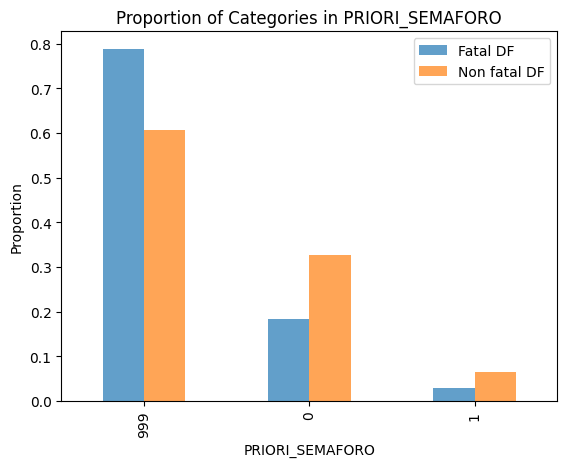

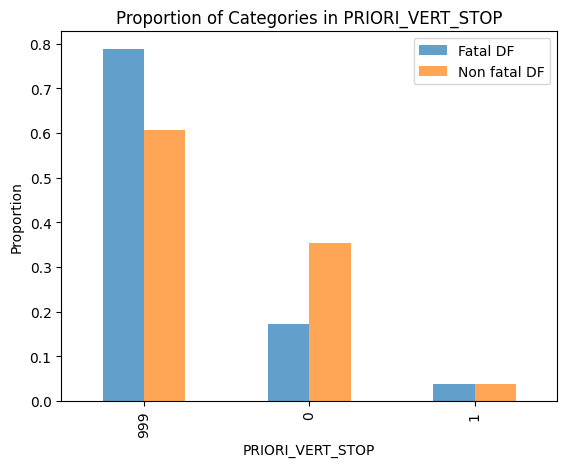

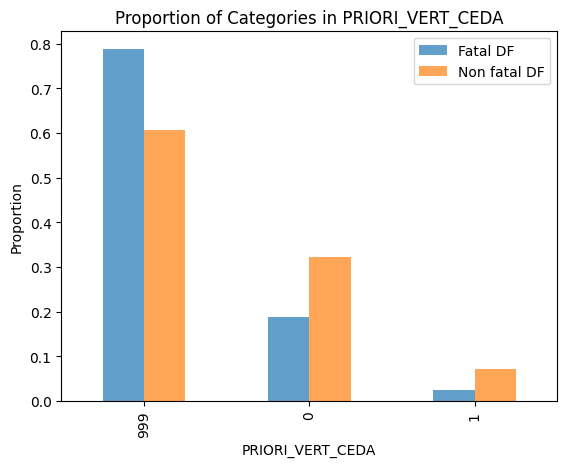

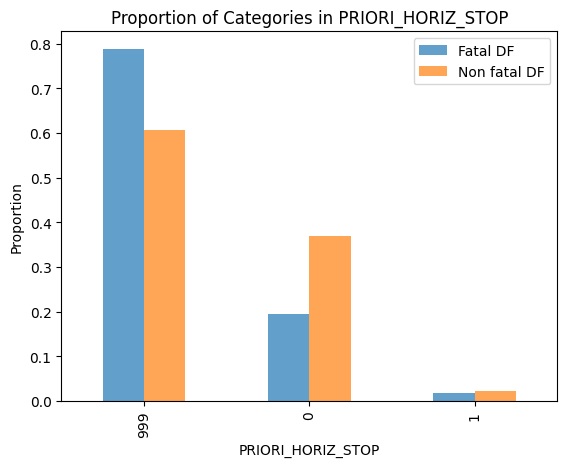

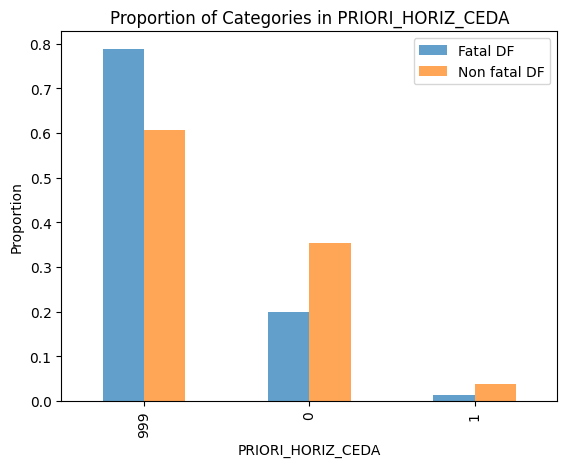

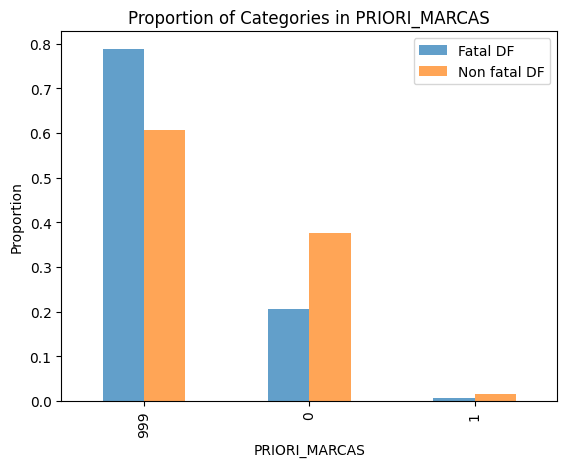

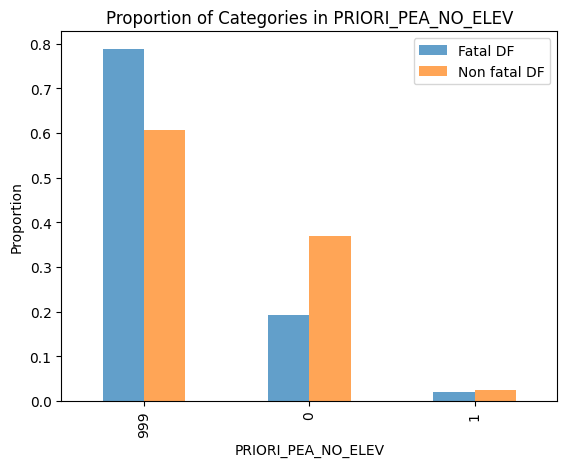

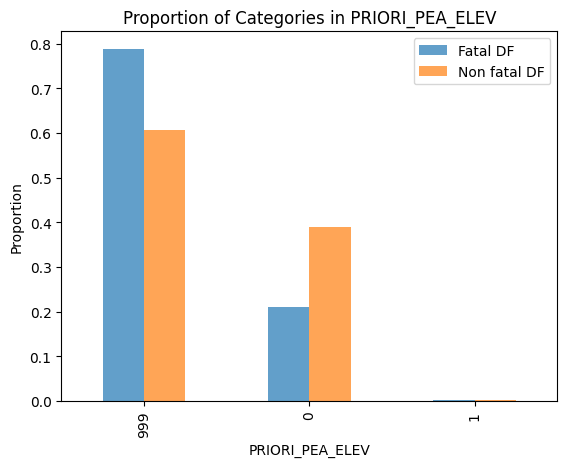

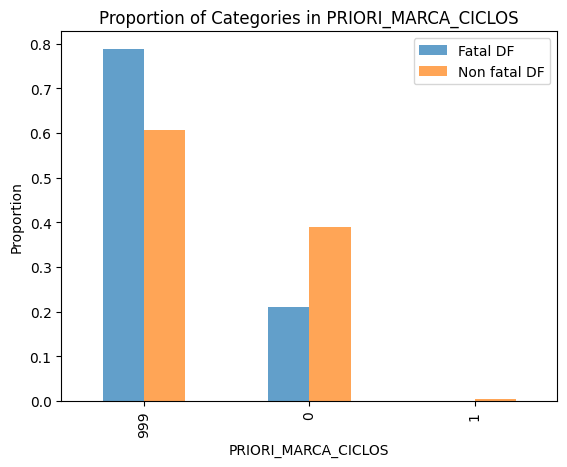

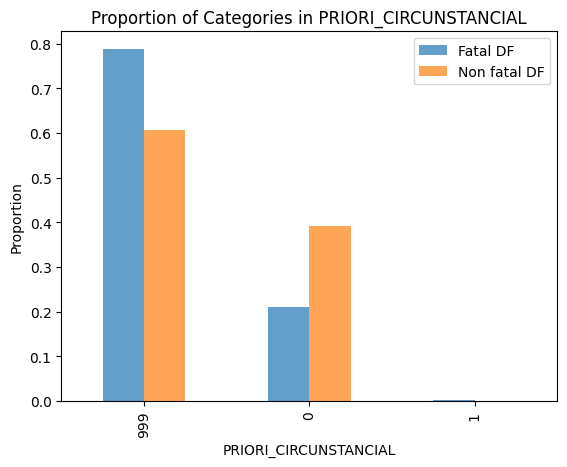

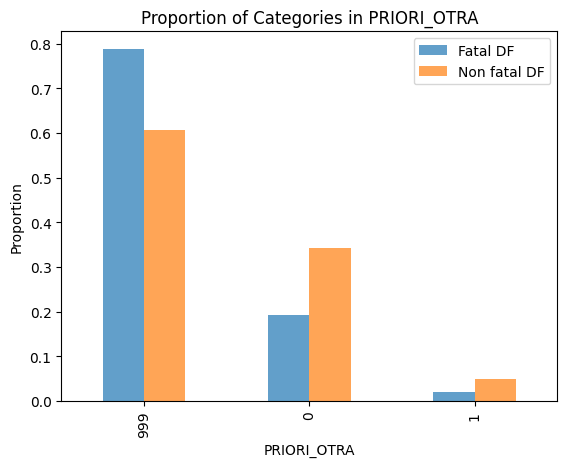

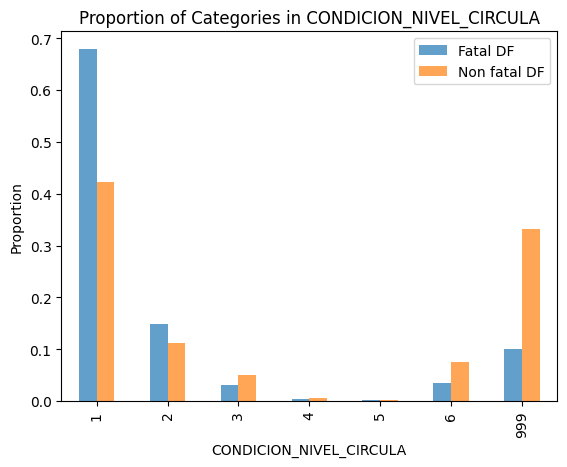

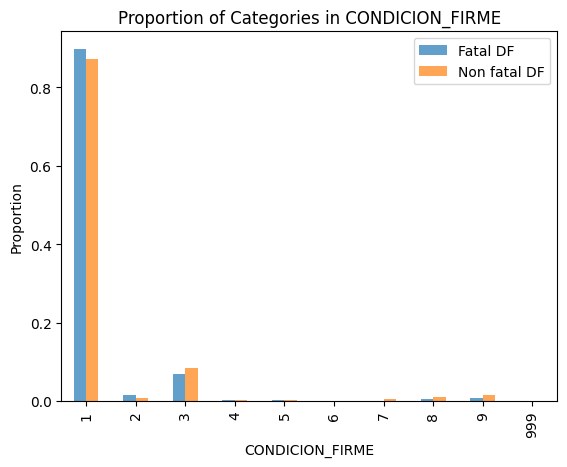

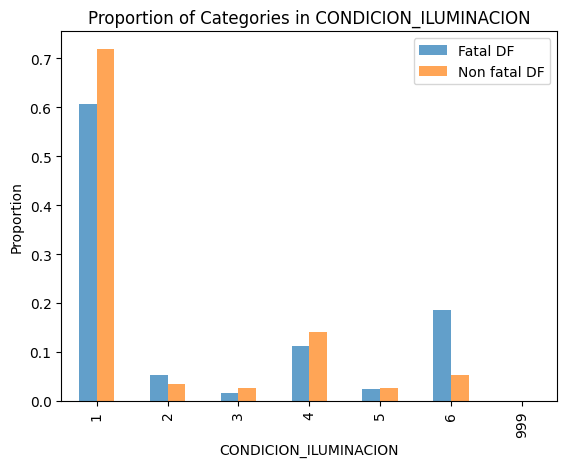

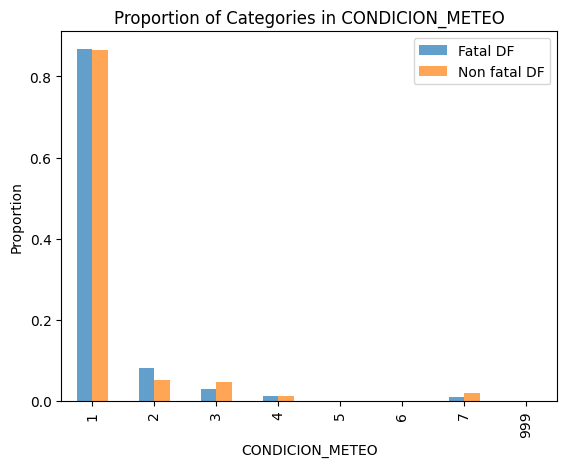

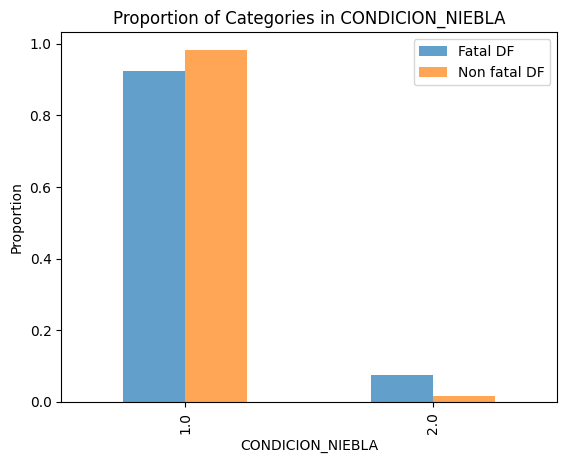

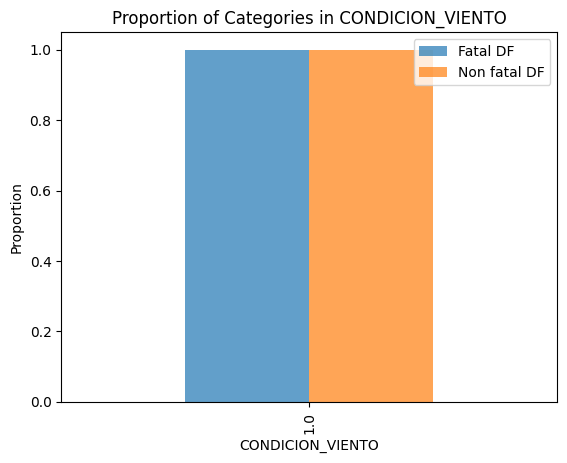

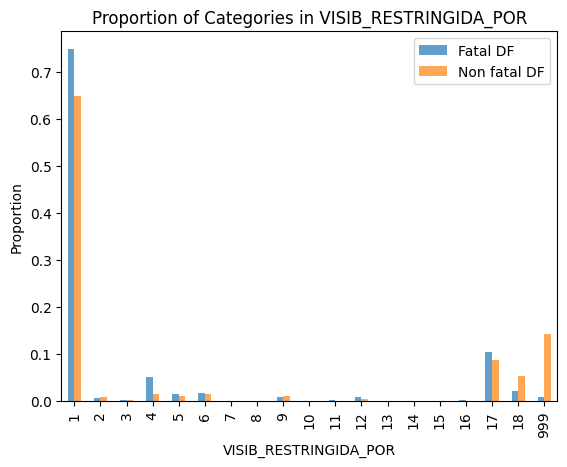

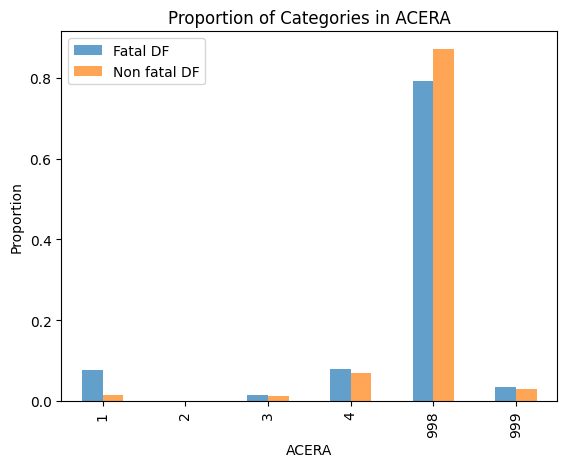

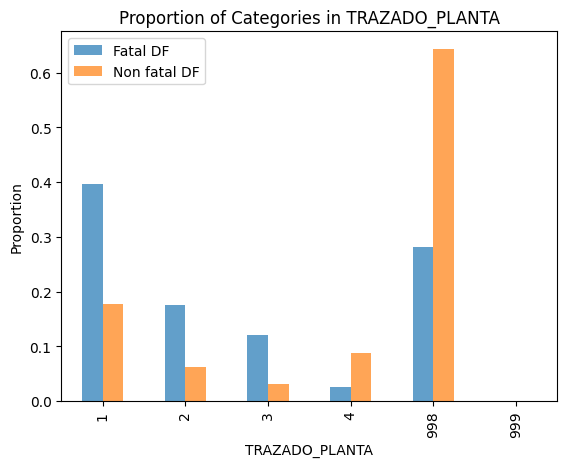

In [8]:
# Calculate the DF with only fatal accidents and withouth fatal accidents
df_fatal = df[df['FATAL_ACCIDENT'] == 1]
df_non_fatal = df[df['FATAL_ACCIDENT'] == 0]

for column in df_fatal.select_dtypes(include=['category']).columns:
  # Calculate proportions
  fatal_proportions = df_fatal[column].value_counts(normalize=True)
  non_fatal_proportions = df_non_fatal[column].value_counts(normalize=True)

  # Create a DataFrame for plotting
  proportions_df = pd.DataFrame({'Fatal DF': fatal_proportions,
                                 'Non fatal DF': non_fatal_proportions}).fillna(0)

  # Plot the proportions
  proportions_df.plot(kind='bar', alpha=0.7)
  plt.title(f'Proportion of Categories in {column}')
  plt.ylabel('Proportion')
  plt.show()

When looking at the graphics, we can clearly some trends like:
- Spain has a **much higher fatality rate in the weekends and in holiday seasons** (summer months + november and december).
- **Fatal accidents use to happen in interurban roads**. We can see it not only in the `ZONA_AGRUPADA` category (the one that indicates 1 if the road where the accident happen is inter-urban and 2 if it is urban) but also in the `ZONA` (showing a big proportion of fatal accidents in inter-urban roads and an inverse proportion in streets) or the `COD_PROVINCIA` (shows a bigger proportion of non-fatal accidents in provinces like Madrid or Barcelona which most of its population lives in big cities).
- **Almost half of the mortal accidents happen in single-lane conventional roads**. The other half is mostly happening in urban roads and expressways. We see it in the `TIPO_VIA` graphic.
- **Most fatal accidents are frontal collisions followed by run-off-road collisions and pedestrian hits.** We see it in `TIPO_ACCIDENTE`.

Let's look a bit deeper into some of these facts.

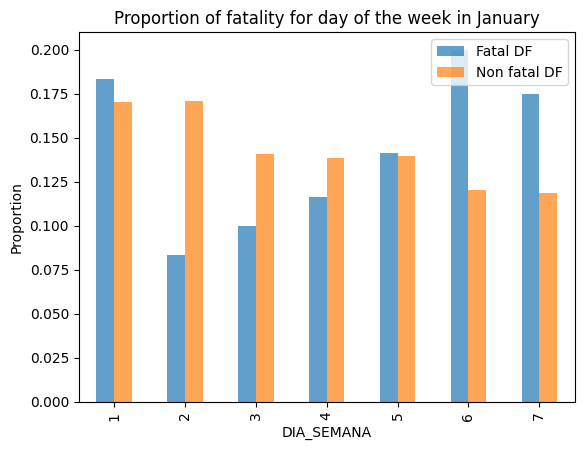

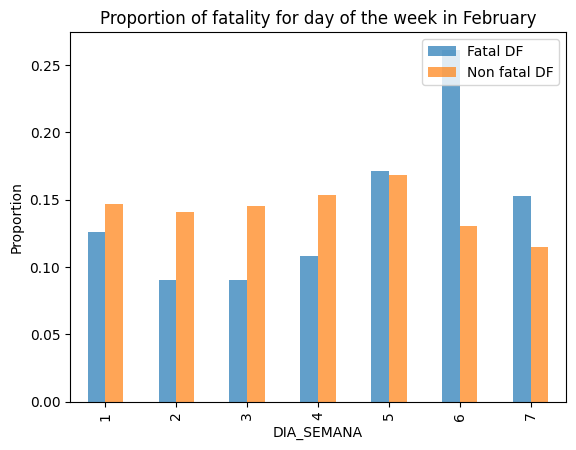

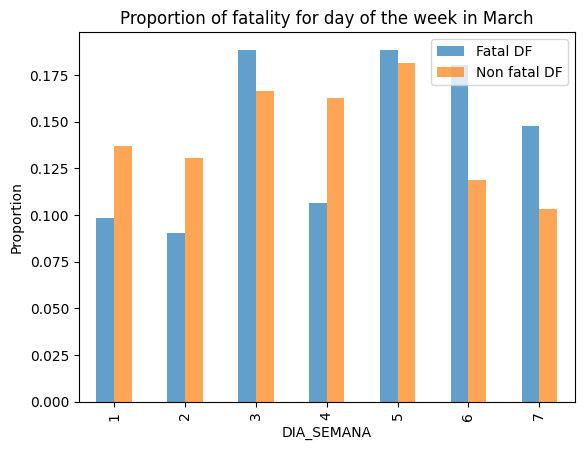

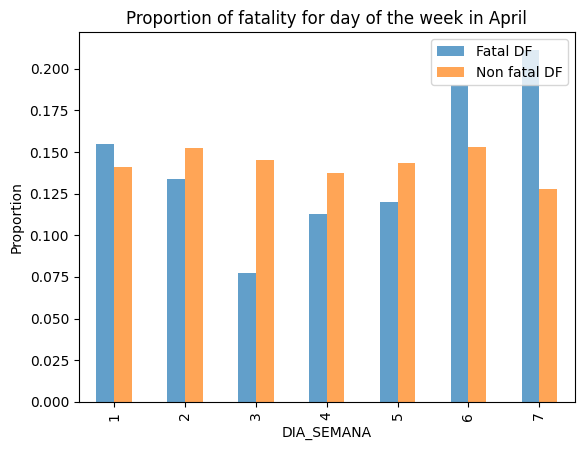

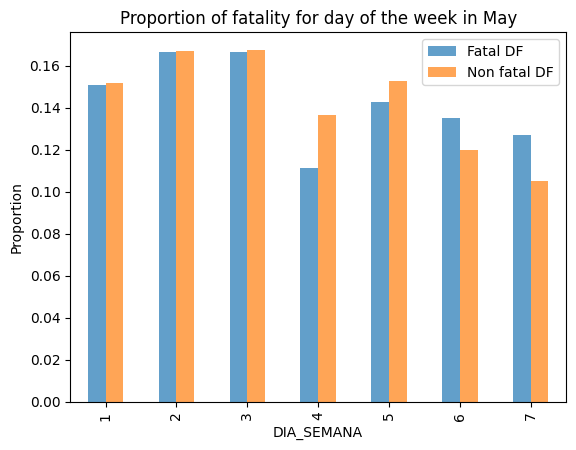

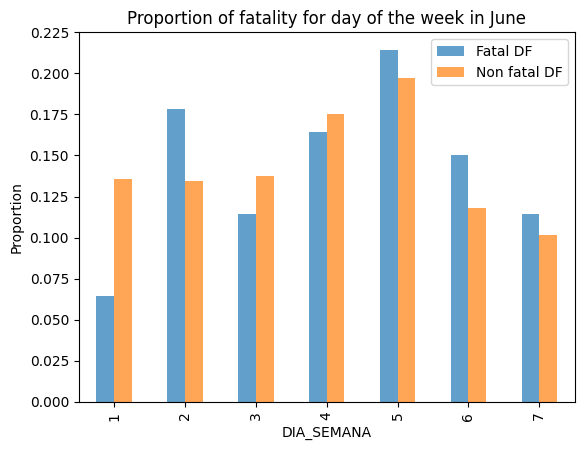

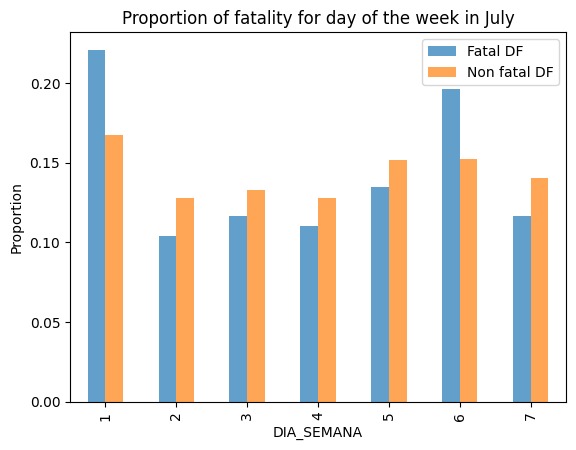

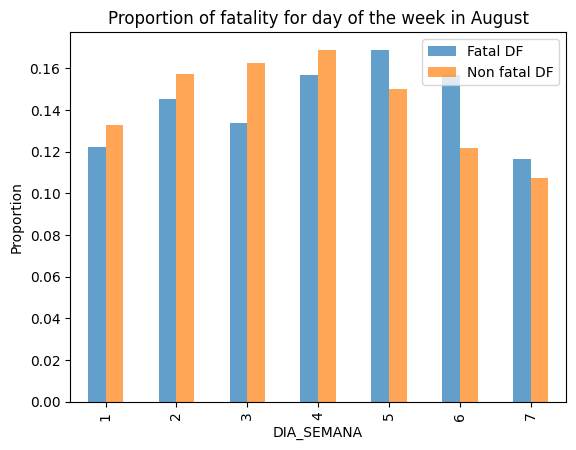

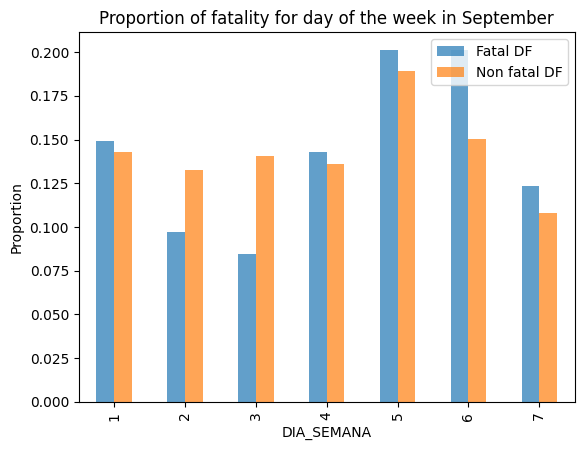

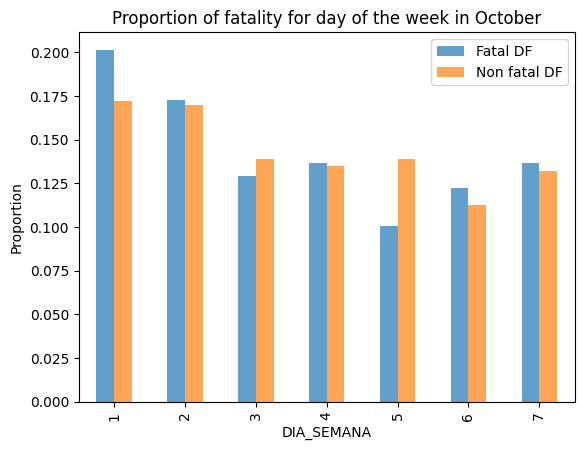

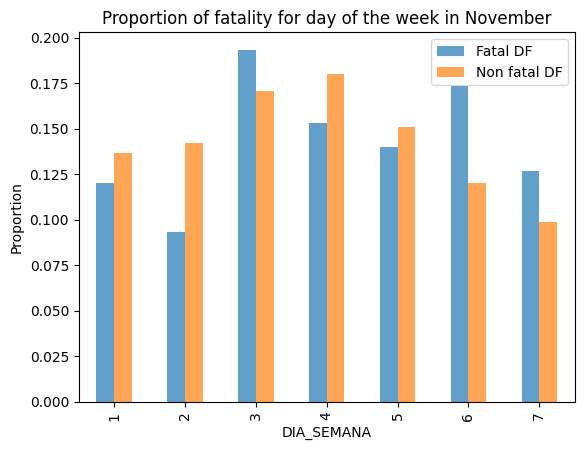

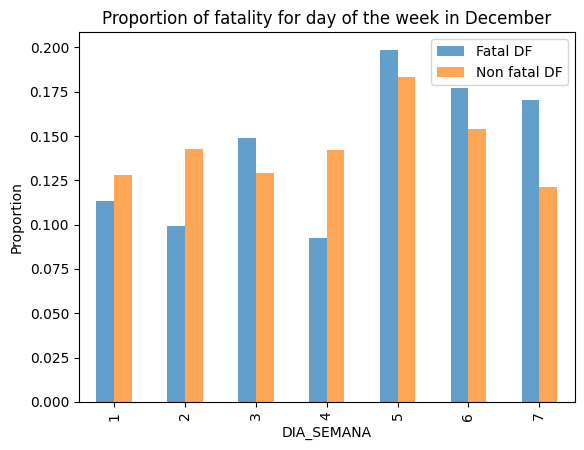

In [9]:
import calendar

for month in range(1, 13):
  # Calculate proportions
  fatal_proportions = df_fatal[df_fatal['MES'] == month]['DIA_SEMANA'].value_counts(normalize=True).sort_index()
  non_fatal_proportions = df_non_fatal[df_non_fatal['MES'] == month]['DIA_SEMANA'].value_counts(normalize=True).sort_index()

  # Create a DataFrame for plotting
  proportions_df = pd.DataFrame({'Fatal DF': fatal_proportions,
                                 'Non fatal DF': non_fatal_proportions}).fillna(0)

  # Plot the proportions
  fig, ax1 = plt.subplots()
  proportions_df.plot(kind='bar', alpha=0.7, ax=ax1)
  ax1.set_title(f'Proportion of fatality for day of the week in {calendar.month_name[month]}')
  ax1.legend(loc='upper right')
  ax1.set_ylabel('Proportion')

  plt.show()


When looking at the fatality rate every weekday for every month, we see that the weekend trend is mostly repeated in non holiday months.

This fact reinforces the hypothesis that fatal accidents happen when people move outside their routines.

Let's now check more in deep the data related to where mortal accidents happen.

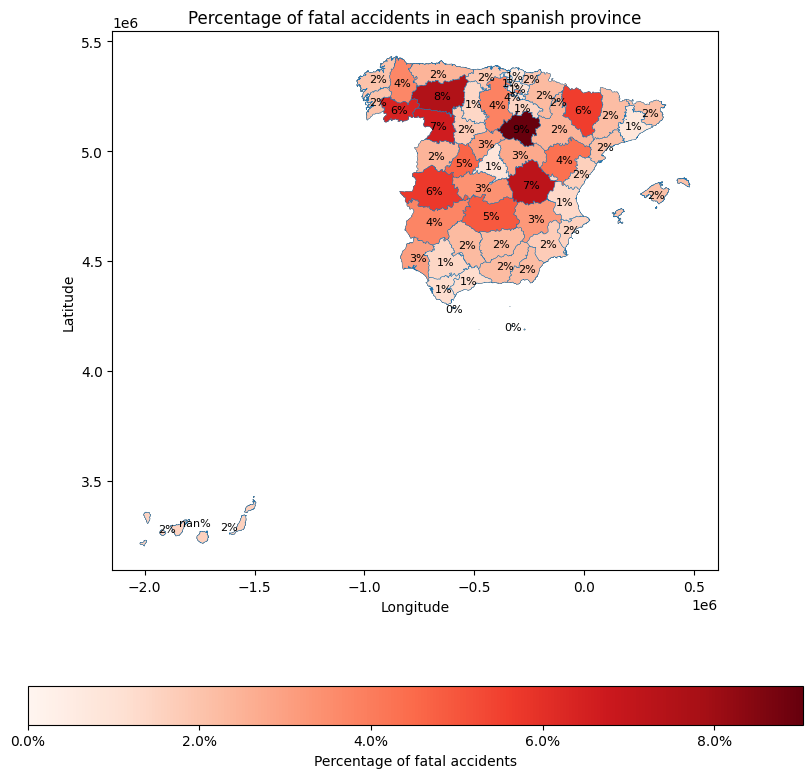

In [10]:
import geopandas as gpd
import requests
import zipfile
import io



# Import the map of Spain
shapefile_link = 'https://stacks.stanford.edu/object/np165yq7060'
# Downloads the file
response = requests.get(shapefile_link)
# Unzips the file
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall('./map')
map = gpd.read_file('./map/ESP_adm2.shp')
map.head()
# Map the province names to the codes in our DF
map['CCA_2'] = pd.to_numeric(map['CCA_2'], errors='coerce')
map['fatal_accidents'] = map['CCA_2'].map(df_fatal['COD_PROVINCIA'].value_counts() / df['COD_PROVINCIA'].value_counts()) # Add the accidents information into the map
map = map.to_crs(epsg=3857)  # Re-project to Web Mercator (EPSG:3857)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
map.plot(ax=ax, color='white', edgecolor='black', linewidth=0.25)
map.boundary.plot(ax=ax, linewidth=0.25)
map.plot(column=map['fatal_accidents']*100, ax=ax, legend=True, cmap=plt.get_cmap('Reds'),
           legend_kwds={'label': "Percentage of fatal accidents",
                        'orientation': "horizontal",
                        'format': '%.1f%%'})

# Add labels for each province
for x, y, label in zip(map.geometry.centroid.x, map.geometry.centroid.y, map['fatal_accidents'].apply(lambda x: f"{x*100:.0f}%")):
    ax.annotate(label, xy=(x, y), xytext=(-6, -3), textcoords="offset points", fontsize=8)

# Customize the plot
ax.set_title('Percentage of fatal accidents in each spanish province')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot & the province codes for reference
plt.show()

As we saw before, Madrid and Barcelona have pretty low fatality rate compared with other areas, probably coming from the great amount of urban population they have.

A curious fact is that it looks like the south and east coast of Spain looks to have a lower fatality rate than the rest of the country, having the interior provinces a much lower fatality rate.

Let's now check the fatality numbers by vehicle type.

In our data we have 11 different type of victims:

- Pedestrians (`TOT_PEAT_MU30DF`)
- Cyclists (`TOT_BICI_MU30DF`)
- Moped drivers / passengers (`TOT_CICLO_MU30DF`)
- Motorbike drivers / passengers (`TOT_MOTO_MU30DF`)
- Tourism car drivers / passengers (`TOT_TUR_MU30DF`)
- Van drivers / passengers (`TOT_FURG_MU30DF`)
- Trucks <3.500kg drivers / passengers (`TOT_CAM_MENOS3500_MU30DF`)
- Trucks >3.500kg drivers / passengers (`TOT_CAM_MAS3500_MU30DF`)
- Bus drivers / passengers (`TOT_BUS_MU30DF`)
- Other drivers / passengers (`TOT_OTRO_MU30DF`)
- Victims without specified type (`TOT_SINESPECIF_MU30DF`)

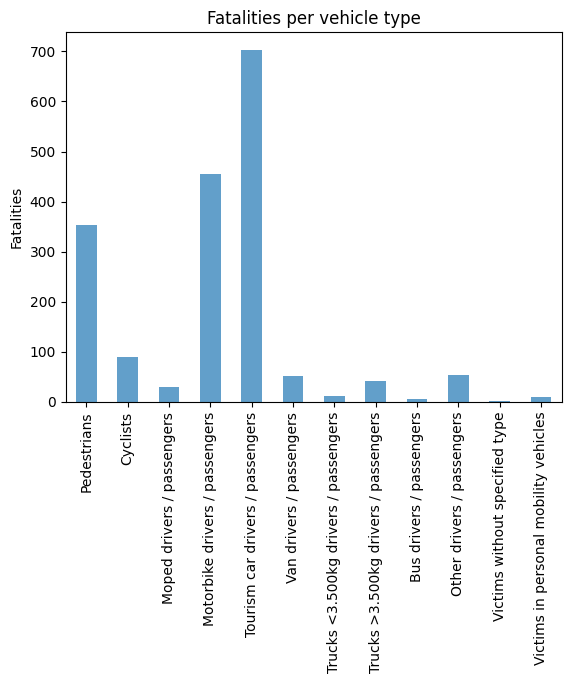

In [11]:
# Draw a bar plot of the different amounts of victims according to their type

fatalities_columns = ['TOT_PEAT_MU30DF', 'TOT_BICI_MU30DF', 'TOT_CICLO_MU30DF',
                      'TOT_MOTO_MU30DF', 'TOT_TUR_MU30DF', 'TOT_FURG_MU30DF',
                      'TOT_CAM_MENOS3500_MU30DF', 'TOT_CAM_MAS3500_MU30DF',
                      'TOT_BUS_MU30DF', 'TOT_OTRO_MU30DF', 'TOT_SINESPECIF_MU30DF',
                      'TOT_VMP_MU30DF']

df_fatalities_per_vehicle = df_fatal[fatalities_columns].sum()
df_fatalities_per_vehicle.rename({'TOT_PEAT_MU30DF':  'Pedestrians',
                                  'TOT_BICI_MU30DF':  'Cyclists',
                                  'TOT_CICLO_MU30DF': 'Moped drivers / passengers',
                                  'TOT_MOTO_MU30DF':  'Motorbike drivers / passengers',
                                  'TOT_TUR_MU30DF':   'Tourism car drivers / passengers',
                                  'TOT_FURG_MU30DF':  'Van drivers / passengers',
                                  'TOT_CAM_MENOS3500_MU30DF': 'Trucks <3.500kg drivers / passengers',
                                  'TOT_CAM_MAS3500_MU30DF': 'Trucks >3.500kg drivers / passengers',
                                  'TOT_BUS_MU30DF': 'Bus drivers / passengers',
                                  'TOT_OTRO_MU30DF': 'Other drivers / passengers',
                                  'TOT_SINESPECIF_MU30DF': 'Victims without specified type',
                                  'TOT_VMP_MU30DF': 'Victims in personal mobility vehicles'}).plot(kind='bar', alpha=0.7)
plt.title(f'Fatalities per vehicle type')
plt.ylabel('Fatalities')
plt.show()

As we can see, most of the registered fatal victims in spanish accidents were onboard of a car or a motorbike, but we have a lot of pedestrians as well.

Given that in 2024 only 16,8% of the registered vehicles in Spain were motorbikes, we can say that the possibility of dying in a road accident is much higher in a motorbike than in a car.

Also we can confirm that pedestrians and cyclists are still a significant part of the people who lost their lives on the spanish roads.

Let's also see what the hour of the day (`HORA`) can tell us about  fatality rate.

<ipython-input-12-ee255849e7e5>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hourly_fatal_proportion = df.groupby('HORA')['FATAL_ACCIDENT'].mean()


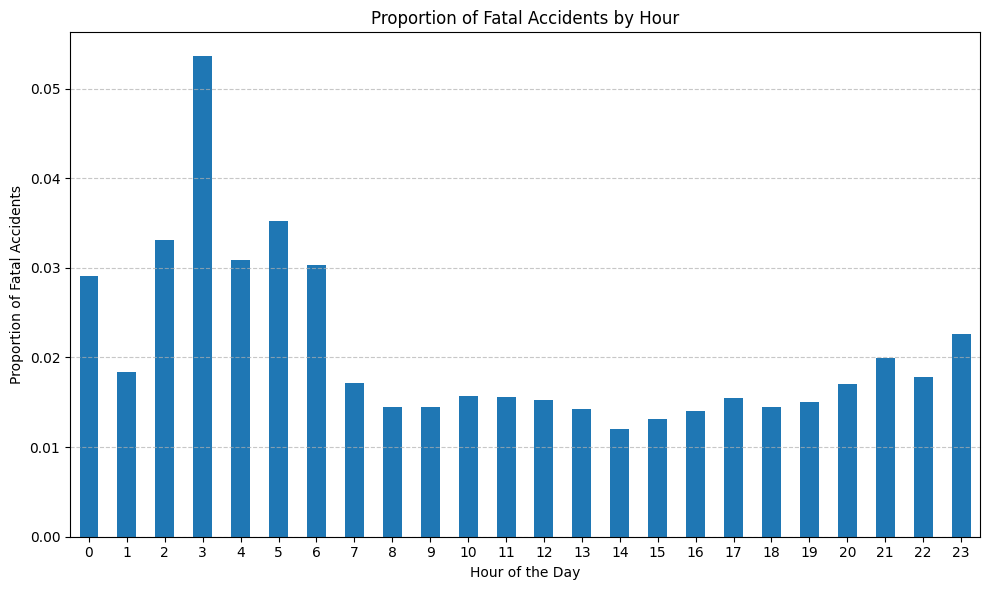

In [12]:
# Group df by hour and calculate the proportion of fatal accidents
hourly_fatal_proportion = df.groupby('HORA')['FATAL_ACCIDENT'].mean()

# Plotting
plt.figure(figsize=(10, 6))
hourly_fatal_proportion.plot(kind='bar')
plt.xlabel('Hour of the Day')
plt.ylabel('Proportion of Fatal Accidents')
plt.title('Proportion of Fatal Accidents by Hour')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

As we could imagine, there are more fatal accidents happening in the night, specially at 3AM. This should be something that the authorities could explore deeper when looking to reduce mortality rate.

Let's now prepare our data for implementing the model.

First of all, let's remove the columns different than `FATAL_ACCIDENT` that include numbers of deceased people. These are `TOTAL_MU24H`, `TOTAL_MU30DF`, `TOTAL_VICTIMAS_24H`, `TOTAL_VICTIMAS_30DF`, `TOT_PEAT_MU24H`, `TOT_BICI_MU24H`, `TOT_CICLO_MU24H`, `TOT_MOTO_MU24H`, `TOT_TUR_MU24H`, `TOT_FURG_MU24H`, `TOT_CAM_MENOS3500_MU24H`, `TOT_CAM_MAS3500_MU24H`, `TOT_BUS_MU24H`, `TOT_OTRO_MU24H`, `TOT_SINESPECIF_MU24H`, `TOT_PEAT_MU30DF`, `TOT_BICI_MU30DF`, `TOT_CICLO_MU30DF`, `TOT_MOTO_MU30DF`, `TOT_TUR_MU30DF`, `TOT_FURG_MU30DF`, `TOT_CAM_MENOS3500_MU30DF`, `TOT_CAM_MAS3500_MU30DF`, `TOT_BUS_MU30DF`, `TOT_OTRO_MU30DF`, `TOT_VMP_MU30DF` and `TOT_SINESPECIF_MU30DF`.

In [13]:
# Remove the columns that include numbers of deceased
df_balanced = df_balanced.drop(['TOTAL_MU24H',
                                'TOTAL_MU30DF',
                                'TOTAL_VICTIMAS_24H',
                                'TOTAL_VICTIMAS_30DF',
                                'TOT_PEAT_MU24H',
                                'TOT_BICI_MU24H',
                                'TOT_CICLO_MU24H',
                                'TOT_MOTO_MU24H',
                                'TOT_TUR_MU24H',
                                'TOT_FURG_MU24H',
                                'TOT_CAM_MENOS3500_MU24H',
                                'TOT_CAM_MAS3500_MU24H',
                                'TOT_BUS_MU24H',
                                'TOT_OTRO_MU24H',
                                'TOT_SINESPECIF_MU24H',
                                'TOT_PEAT_MU30DF',
                                'TOT_BICI_MU30DF',
                                'TOT_CICLO_MU30DF',
                                'TOT_MOTO_MU30DF',
                                'TOT_TUR_MU30DF',
                                'TOT_FURG_MU30DF',
                                'TOT_CAM_MENOS3500_MU30DF',
                                'TOT_CAM_MAS3500_MU30DF',
                                'TOT_BUS_MU30DF',
                                'TOT_OTRO_MU30DF',
                                'TOT_SINESPECIF_MU30DF',
                                'TOT_VMP_MU30DF'], axis=1)

df_balanced.head()

,MES,DIA_SEMANA,HORA,COD_PROVINCIA,COD_MUNICIPIO,ISLA,ZONA,ZONA_AGRUPADA,CARRETERA,KM,...,CONDICION_NIVEL_CIRCULA,CONDICION_FIRME,CONDICION_ILUMINACION,CONDICION_METEO,CONDICION_NIEBLA,CONDICION_VIENTO,VISIB_RESTRINGIDA_POR,ACERA,TRAZADO_PLANTA,FATAL_ACCIDENT
0,7,5,21,35,35016,7.0,3,2,No inventariada,NaN,...,999,1,4,1,NaN,NaN,1,4,998,1
1,4,6,10,29,29094,NaN,3,2,No inventariada,NaN,...,2,1,1,1,NaN,NaN,1,998,998,0
2,11,3,9,41,41053,NaN,3,2,No inventariada,NaN,...,999,1,1,1,NaN,NaN,1,998,998,0
3,8,6,12,17,0,NaN,1,1,C-31,379.00,...,2,1,1,1,NaN,NaN,17,998,1,1
4,7,5,6,38,38001,10.0,1,1,TF-1,75.45,...,1,1,6,1,NaN,NaN,1,1,1,1


We will also remove the `KM` column as indicates the kilometric point of the road where the accident happen and it may be misleading as the same kilometric point can be a totally different place for different roads.

In [14]:
df_balanced = df_balanced.drop('KM', axis=1)

Now let's create the train and test datasets.

In [15]:
# Separate x and y datasets
y = df_balanced['FATAL_ACCIDENT']
X = df_balanced.drop('FATAL_ACCIDENT', axis=1)

from sklearn.model_selection import train_test_split

# Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


After reading [Machine learning predictive model based on national data for fatal accidents of construction workers](https://www.sciencedirect.com/science/article/abs/pii/S0926580519305151) by Jongko Choi, Bonsung Gu, Sangyoon Chin, Jong-Seok Lee, I decided to proceed with a model based on a Random Forest Classifier as it was predictive model that performed the best when classifying workers who might face a fatality risk.

In addition to this, the Pandas Random Forest Classifier provides built-in feature importance scores. These scores indicate how much each feature contributes to the model's predictions. This help us identify which are the factors that contribute the most to fatality in road accidents.

To be able to use the RandomForestClassifier, we need to first convert all our columns to numerical and impute NaNs. We will do it in the following code block creating a pipeline. Later, we will fit the pipeline.

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define categorical and numerical columns
categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])

# Create the full pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the model
clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['TOTAL_HG24H', 'TOTAL_HL24H',
                                                   'TOTAL_HG30DF',
                                                   'TOTAL_HL30DF',
                                                   'TOTAL_VEHICULOS']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['MES', 'DIA_SEMANA', 'HORA',
                                                   'COD_PROVINCIA',
                                                   'COD_MUNICIPIO...
                                                   'CARRETERA_CRUCE',
                                                   'PRIORI_NORMA',
                                                   'PRIORI_AGENTE',
                                                   'PRIORI_SEMAFORO',
                                                   'PRIORI_VERT_STOP',
                                                   'PRIORI_VERT_CEDA',
                                                   'PRIORI_HORIZ_STOP',
                                                   'PRIORI_HORIZ_CEDA',
                                                   'PRIORI_MARCAS',
                                                   'PRIORI_PEA_NO_ELEV',
                                                   'PRIORI_PEA_ELEV',
                                                   'PRIORI_MARCA_CICLOS',
                                                   'PRIORI_CIRCUNSTANCIAL',
                                                   'PRIORI_OTRA',
                                                   'CONDICION_NIVEL_CIRCULA', ...])])),
                ('classifier', RandomForestClassifier(random_state=42))])

Let's now test the accuracy of our model.

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def test_model(model, X_test, y_test):
  # Predict on the test set
  y_pred = model.predict(X_test)

  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)

  print(f"Accuracy: {accuracy:.2f}")

  # Generate and print confusion matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  print("Confusion Matrix:")
  print(conf_matrix)

  # Generate and print classification report
  class_report = classification_report(y_test, y_pred)
  print("Classification Report:")
  print(class_report)

test_model(clf, X_test, y_test)


Accuracy: 0.86
Confusion Matrix:
[[284  34]
 [ 57 297]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       318
           1       0.90      0.84      0.87       354

    accuracy                           0.86       672
   macro avg       0.87      0.87      0.86       672
weighted avg       0.87      0.86      0.86       672



As we see, our model looks to have a pretty high accuracy.

Our goal now is to see which features are the most important when predicting the fatal accidents.

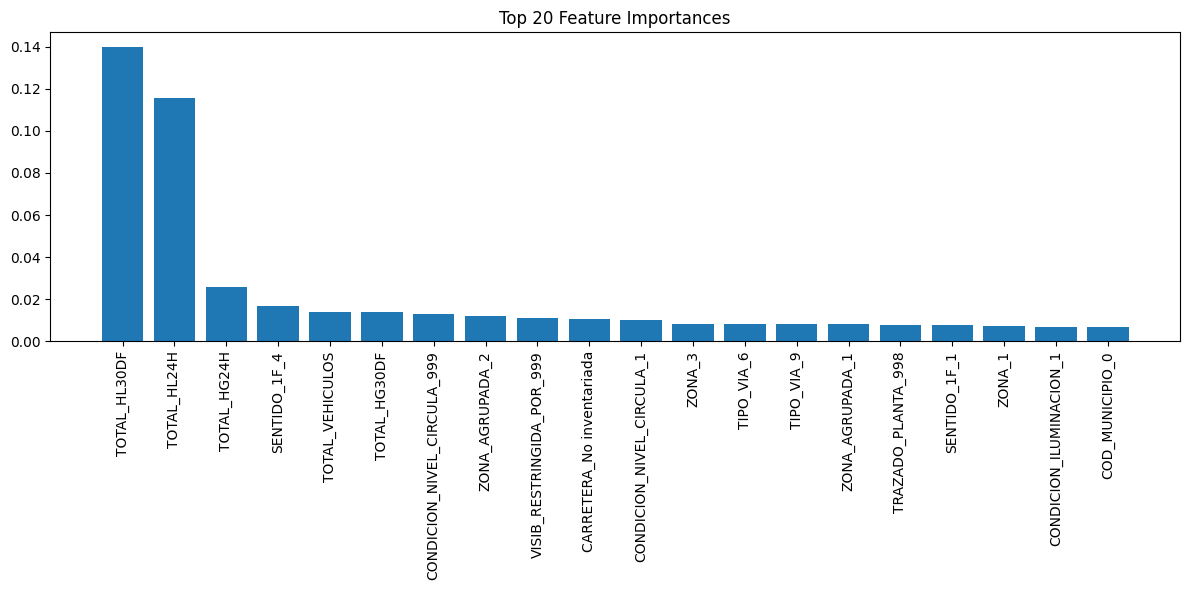

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get feature importances from the classifier
importances = clf.named_steps['classifier'].feature_importances_

# Get feature names from the preprocessor
num_features = clf.named_steps['preprocessor'].transformers_[0][2]
cat_transformer = clf.named_steps['preprocessor'].transformers_[1][1]
cat_cols = clf.named_steps['preprocessor'].transformers_[1][2]
cat_features = cat_transformer.named_steps['onehot'].get_feature_names_out(cat_cols)

# Combine all feature names
feature_names = np.concatenate([num_features, cat_features])

# Create a DataFrame with feature importances
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort and select top 20 features
top_20 = feature_importances.sort_values(by='importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(len(top_20)), top_20['importance'], align="center")
plt.xticks(range(len(top_20)), top_20['feature'], rotation=90)
plt.tight_layout()
plt.show()



The features with most importance are obviously the number of injured people in the accident. Surprisingly, the features registering minor injuries have more importance than the ones registering major injuries.

We can see that the other features don't show a super high importance compared with the number of minor injuries.

We can check how accuracy changes if we drop the columns related to injured victims.

In [19]:
# Drop columns including injured
df_balanced_no_injured = df_balanced.drop(['TOTAL_HG24H',
                                           'TOTAL_HL24H',
                                           'TOTAL_HG30DF',
                                           'TOTAL_HL30DF'], axis=1)
# Separate x and y datasets
y = df_balanced_no_injured['FATAL_ACCIDENT']
X = df_balanced_no_injured.drop('FATAL_ACCIDENT', axis=1).copy()

# Define categorical and numerical columns
categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])

# Create the full pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
clf.fit(X_train, y_train)

# Test the model
test_model(clf, X_test, y_test)


Accuracy: 0.75
Confusion Matrix:
[[232  86]
 [ 83 271]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       318
           1       0.76      0.77      0.76       354

    accuracy                           0.75       672
   macro avg       0.75      0.75      0.75       672
weighted avg       0.75      0.75      0.75       672



We still have decent accuracy but obviously much less than before. We will refine our pipeline now by trying few things:

1. Add engineered features
2. Doing RandomSearch to look for better parameters that should help obtain better accuracy.

We will first try adding some engineered features:
1. Weekend: 1 if weekend else 0
2. Night: 1 if hour between 0 and 8 and between 21 and 24 else 0
3. inStreet: 1 if accident happened in a street else 0

In [20]:
X['Weekend'] = X['DIA_SEMANA'].apply(lambda x: 1 if x == 6 or x == 7 else 0)
X['Night'] = X['HORA'].apply((lambda x: 1 if x >= 0 and x <= 8 or x >= 21 and x <= 24 else 0))
X['inStreet'] = X['TIPO_VIA'].apply(lambda x: 1 if x == 9 else 0)

Now we have to rebuild the pipeline again, fit it and test it.

In [21]:
# Define categorical and numerical columns
categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])

# Create the full pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
clf.fit(X_train, y_train)

# Test the model
test_model(clf, X_test, y_test)

Accuracy: 0.73
Confusion Matrix:
[[229  89]
 [ 90 264]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       318
           1       0.75      0.75      0.75       354

    accuracy                           0.73       672
   macro avg       0.73      0.73      0.73       672
weighted avg       0.73      0.73      0.73       672



We see that we obtained a worst result in the metrics of our model so we will not keep this new engineered features.



In [29]:
X = X.drop(['Weekend', 'Night', 'inStreet'], axis=1)

Now let's proceed with the second upgrade which is tuning the parameters. For that, we will use RandomizedSearch.

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'classifier__n_estimators': randint(100, 1000),
    'classifier__max_depth': randint(3, 30),
    'classifier__min_samples_split': randint(2, 20),
    'classifier__min_samples_leaf': randint(1, 20),
    'classifier__max_features': ['auto', 'sqrt', 'log2', None],
    'classifier__bootstrap': [True, False]
}

# Create RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_distributions,
    n_iter=50,  # number of parameter settings that are sampled
    scoring='recall',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Run the search
search.fit(X_train, y_train)

print(f"Best CV Recall: {search.best_score_:.4f}")
print("Best hyper-parameters:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")

# Retrieve the tuned pipeline
best_model = search.best_estimator_

# Save best model
import joblib
joblib.dump(best_model, 'rf_pipeline_best.pkl')


Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
36 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l

Best CV Recall: 0.8084
Best hyper-parameters:
  classifier__bootstrap: False
  classifier__max_depth: 5
  classifier__max_features: None
  classifier__min_samples_leaf: 3
  classifier__min_samples_split: 19
  classifier__n_estimators: 995


['rf_pipeline_best.pkl']

In [23]:
test_model(best_model, X_test, y_test)

Accuracy: 0.76
Confusion Matrix:
[[200 118]
 [ 45 309]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.63      0.71       318
           1       0.72      0.87      0.79       354

    accuracy                           0.76       672
   macro avg       0.77      0.75      0.75       672
weighted avg       0.77      0.76      0.75       672



We achieved a great improvement in our target metric (recall) and a small improvement in accuracy. Now we know that our model can detect with almost 90% accuracy the accidents with fatal victims.

On the other hand we increased a lot the number of false positives which may lead to efforts on reducing the chance of fatality in already non-fatal accidents.

Looking at the hyperparameters in the best model we can say that the optimizer pushed the forest toward many very simple, fully-informed trees built on all data.

Now, let's see the importance of each feature like we did before.

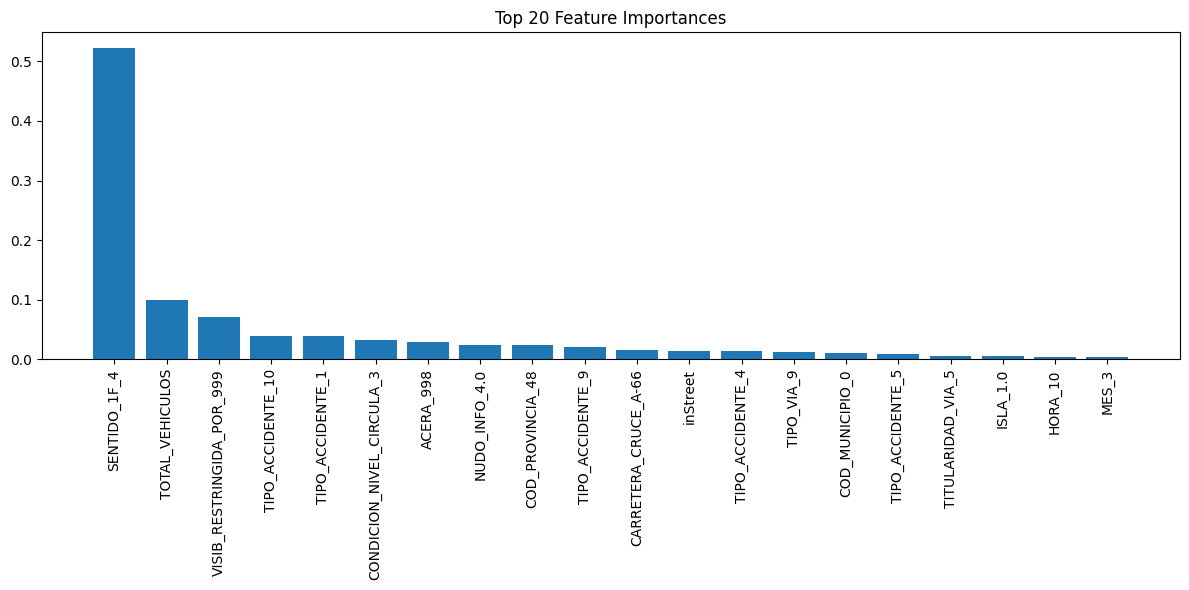

In [24]:
import numpy as np

# Get feature importances from the classifier
importances = best_model.named_steps['classifier'].feature_importances_

# Get feature names from the preprocessor
num_features = best_model.named_steps['preprocessor'].transformers_[0][2]
cat_transformer = best_model.named_steps['preprocessor'].transformers_[1][1]
cat_cols = best_model.named_steps['preprocessor'].transformers_[1][2]
cat_features = cat_transformer.named_steps['onehot'].get_feature_names_out(cat_cols)

# Combine all feature names
feature_names = np.concatenate([num_features, cat_features])

# Create a DataFrame with feature importances
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort and select top 20 features
top_20 = feature_importances.sort_values(by='importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(len(top_20)), top_20['importance'], align="center")
plt.xticks(range(len(top_20)), top_20['feature'], rotation=90)
plt.tight_layout()
plt.show()

We see that by far the most relevant feature is `SENTIDO_1F` when it is 4. When `SENTIDO_1F` is equal to 1 it means that the vehicle was going in the direction that augments the kilometric point of the road, 2 when its in the opposite direction, 3 when both and 4 when unknown.

When `SENTIDO_1F`is unknown is most probably because the road itself doesn't have kilometric points. In Spain, those roads are basically urban roads and the highways, which we know for the statistical analysis that are the ones with lower fatality rates.

This makes much sense as basically this feature indicates that the road where the accident happened should be a safe road.

In this regard we also see in the top20 features like `inStreet` or `TIPO_VIA_9` which clearly indicate streets.

On the other hand we also see features like the number of vehicles taking part in the accident (`TOTAL_VEHICULOS`). We can explore this later.

Other interesting findings are `CONDICION_ILUMINACION_6` which means that there was no artificial or natural light in the accident (may lead to think about nightime) or `ACERA_998` which means that the information about the sidewalk does not apply (may lead to think about interurban roads).

Another repeated column in the features with most importance seems to be the accident type. Because of that, let's see the feature importance of the type of accidents and type of roads.

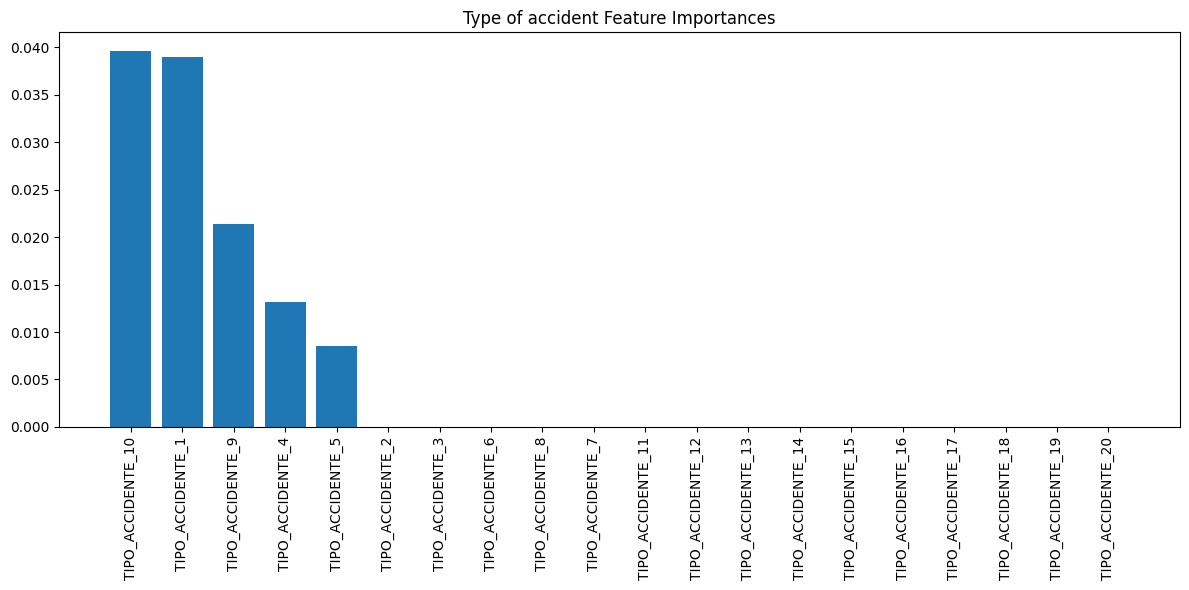

In [25]:
# Filter features that contain 'TIPO_ACCIDENTE'
filtered = feature_importances[feature_importances['feature'].str.contains('TIPO_ACCIDENTE')].sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.title("Type of accident Feature Importances")
plt.bar(range(len(filtered)), filtered['importance'], align="center")
plt.xticks(range(len(filtered)), filtered['feature'], rotation=90)
plt.tight_layout()
plt.show()

We basically see 5 types of accidents with the highest feature importance.

- Type 1: Frontal crash
- Type 10: Fall
- Type 4: Read-end
- Type 16: Run-off-road with crash to the right side
- Type 8: Animal runover

It's interesting to see that pedestrian runover doesn't have importance in predicting the fatality of an accident when there are so many pedestrian deads due to these type of accidents.

Looking at our descriptive statistics from before, we can tell that probably a frontal crash or a run-off-road with crash to the right side will predict a fatal accident and that a fall, a rear-end or an animal runover may predict a non fatal accident.

**This shows us that both administrations and car manufacturers have to keep working on improving the security of cars and roads against frontal collisions and run-off-road collisions.**

Let's now see the importance of the type of roads.

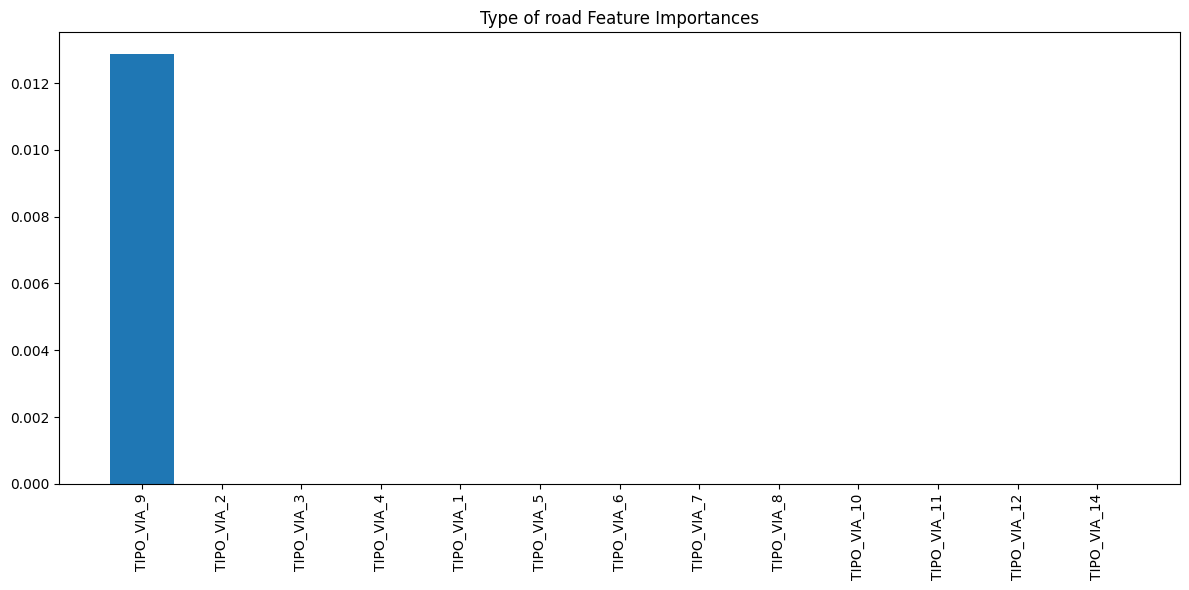

In [26]:
# Filter features that contain 'TIPO_VIA'
filtered = feature_importances[feature_importances['feature'].str.contains('TIPO_VIA')].sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
plt.title("Type of road Feature Importances")
plt.bar(range(len(filtered)), filtered['importance'], align="center")
plt.xticks(range(len(filtered)), filtered['feature'], rotation=90)
plt.tight_layout()
plt.show()

Let's analyze deeper the `TOTAL_VEHICULOS` feature.

Let's see in a plot how the fatality rate evolves in relationship with the total amount of vehicles involved in an accident.

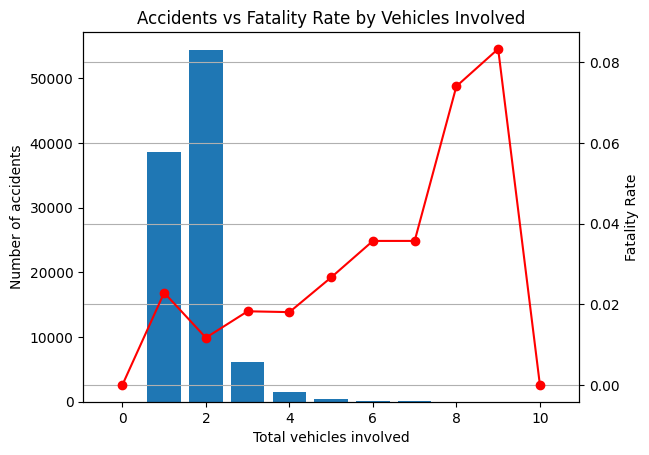

In [27]:
# Aggregate data: count accidents and fatality_rate by vehicles involved
agg = df[df['TOTAL_VEHICULOS'] <= 10].groupby('TOTAL_VEHICULOS').agg(
    accidents=('index' if 'index' in df.columns else 'FATAL_ACCIDENT', 'size'),
    fatality_rate=('FATAL_ACCIDENT', 'mean')).reset_index()

fig, ax1 = plt.subplots()

# Bar chart: number of accidents per vehicle count
ax1.bar(agg['TOTAL_VEHICULOS'], agg['accidents'])
ax1.set_xlabel('Total vehicles involved')
ax1.set_ylabel('Number of accidents')

# Secondary axis for fatality_rate line
ax2 = ax1.twinx()
ax2.plot(agg['TOTAL_VEHICULOS'], agg['fatality_rate'], marker='o', color='red')
ax2.set_ylabel('Fatality Rate')

plt.title('Accidents vs Fatality Rate by Vehicles Involved')
plt.grid(axis='y')
plt.show()

The graphic shows us that for most fatal accidents, surprisingly more frequent there is only one vehicle involved.

Let's see fatal accidents with just one vehicle involved by accident type.

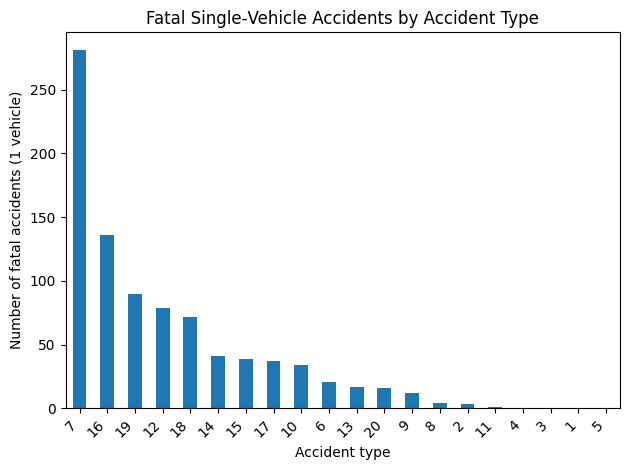

In [28]:
# Filter to fatal accidents with exactly one vehicle
subset = df[(df['TOTAL_VEHICULOS'] == 1) & (df['FATAL_ACCIDENT'] == 1)]

# Count fatal accidents per accident type
counts = subset['TIPO_ACCIDENTE'].value_counts().sort_values(ascending=False)

plt.figure()
counts.plot(kind='bar')
plt.xlabel('Accident type')
plt.ylabel('Number of fatal accidents (1 vehicle)')
plt.title('Fatal Single‑Vehicle Accidents by Accident Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

We see that they are mostly pedestrian hits and run-off-road accidents. This is again a clear sign for administration to look on this.